In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.datasets import daocensus_text
import src.utils.notebooks as nbutils

sns.set_theme()
plt.rcParams['figure.dpi'] = 300

In [2]:
# 'ORG_NAME', 'ORG_PLATFORM', 'SPLITS_FREQ', 'SPLITS_NORMALIZE', 'LAST_SPLITS', 'USE_ORG_NAMES'

ORG_NAME = 'Decentraland'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES = True

# Not used
SPLITS_FREQ = ...
SPLITS_NORMALIZE = ...
LAST_SPLITS = ...
CUTOFF_DATE_STR = ...

In [3]:
# Parameters
ORG_NAME = "HUWA-DAO"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "3d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-21"
CUTOFF_DATE_STR = None


In [4]:
dfv, dfp = daocensus_text.get('./data/daos-census-text', ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 4151 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4151 entries, 0 to 4150
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       4151 non-null   object        
 1   name           4151 non-null   object        
 2   id             4151 non-null   object        
 3   proposal       4151 non-null   category      
 4   deployment     4151 non-null   object        
 5   platform_vote  4151 non-null   object        
 6   voter          4151 non-null   category      
 7   date           4151 non-null   datetime64[ns]
 8   choice         4151 non-null   object        
 9   weight         4151 non-null   float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 322.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 572 entries, fc7f3d1e-19a3-561b-a4ff-41a4bb31b6d1 to cd62de67-0773-5284-b2f8-7a654f801ad

# Exploración de datos de Decentraland

In [5]:
print(f"{ORG_NAME} tiene {len(dfv)} votos de {dfv['voter'].nunique()} voters en {dfv['proposal'].nunique()} propuestas")

HUWA-DAO tiene 4151 votos de 1331 voters en 572 propuestas


In [6]:
dfd = dfp[['platform', 'name', 'platform_deployment']].drop_duplicates()
dfd

,platform,name,platform_deployment
id,,,
fc7f3d1e-19a3-561b-a4ff-41a4bb31b6d1,snapshot,HUWA-DAO,huwacoin.eth


## Histograma de votos por usuario

1331
0
count    1331.000000
mean        3.118708
std         3.938364
min         1.000000
50%         2.000000
90%         6.000000
95%         9.500000
99%        20.700000
max        43.000000
dtype: float64


Cannot show ipywidgets in text

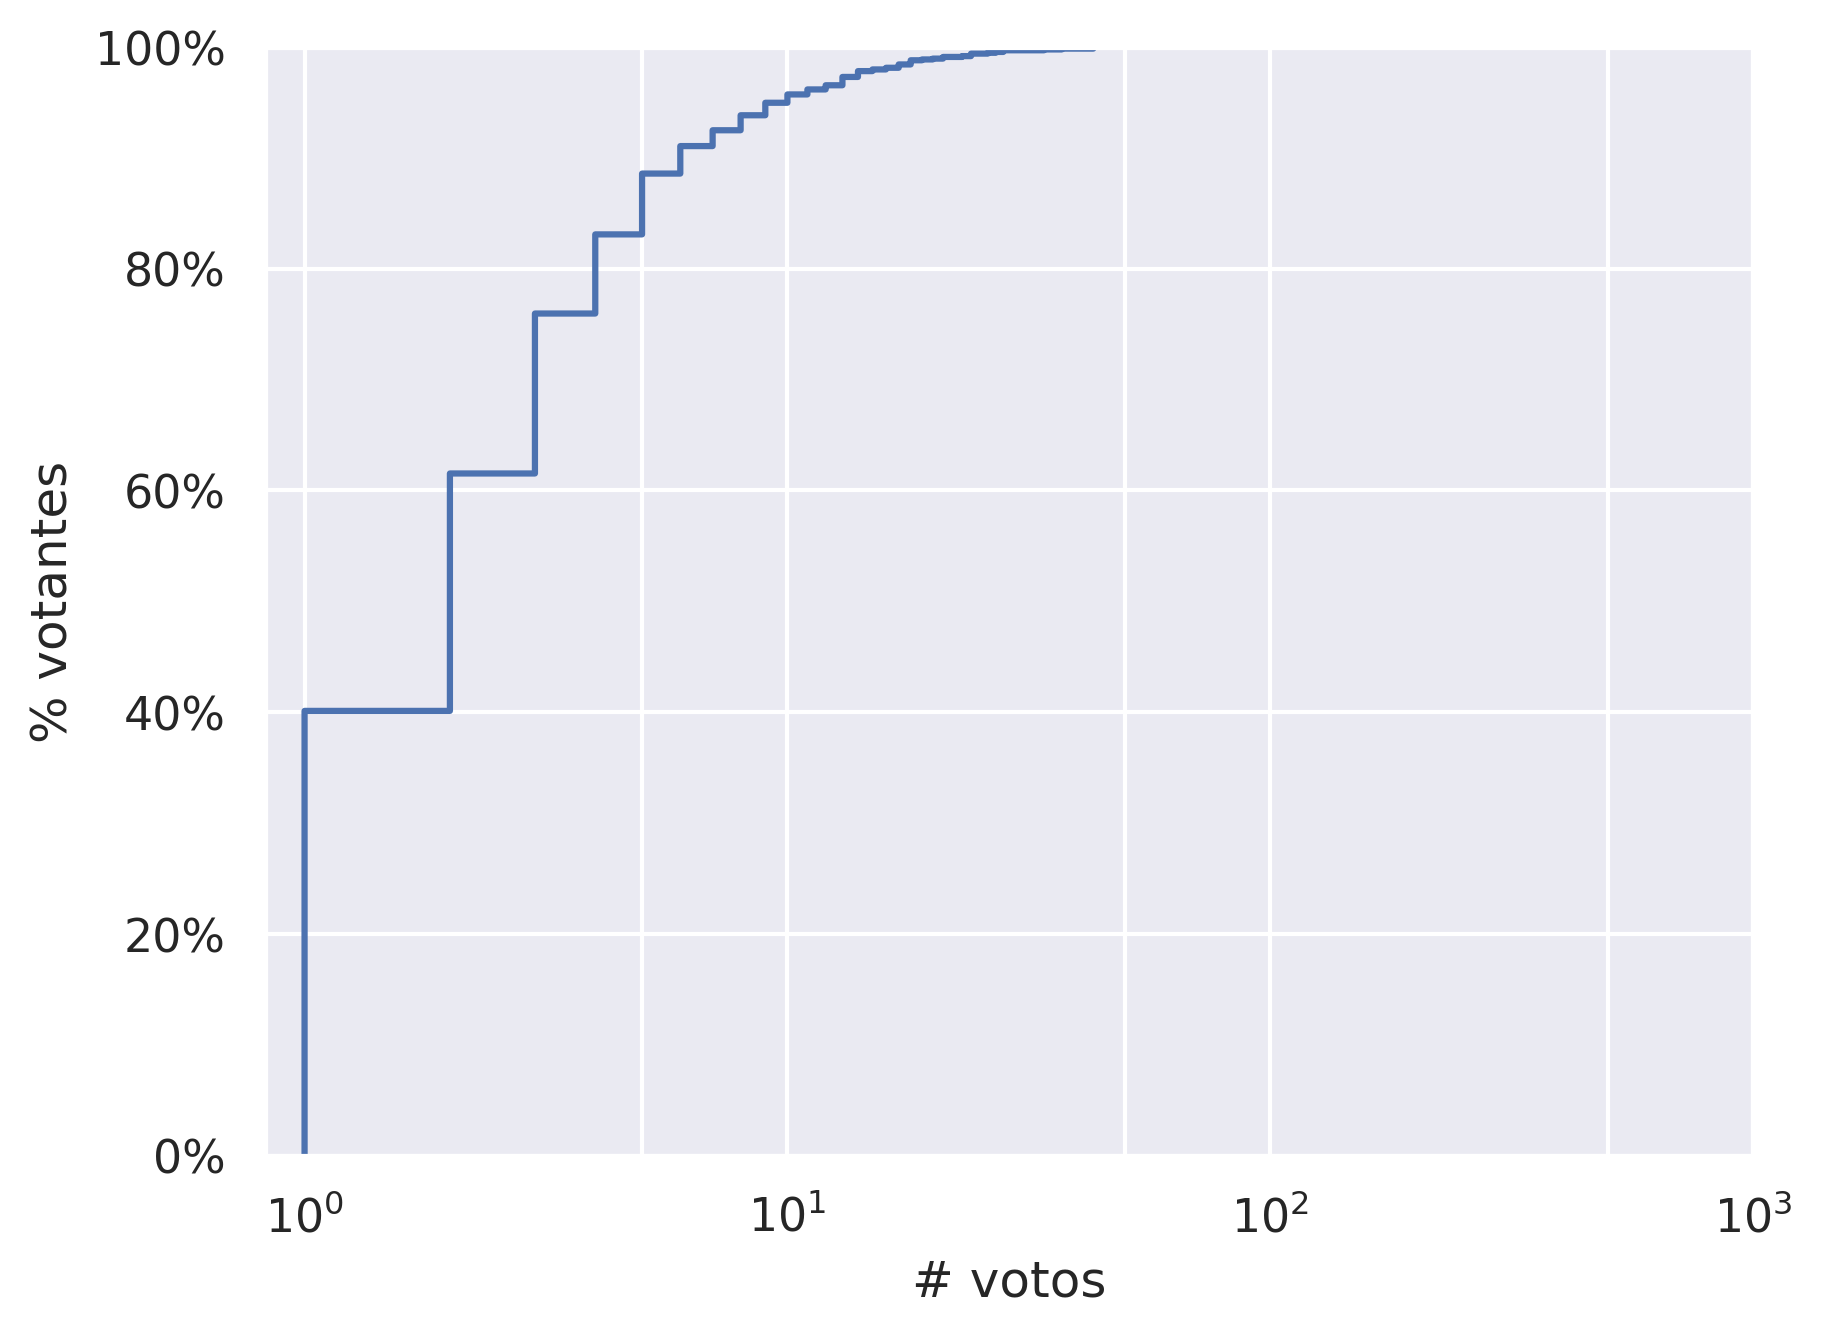

In [7]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print( len(_toplot) )
print( (_toplot > 100).sum() )
print(_toplot.describe(percentiles=[.5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votos')
plt.ylabel('% votantes')

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_voters_{ORG_NAME}.pdf')

## Histograma de votos por propuesta

count    572.000000
mean       7.256993
std       11.809434
min        1.000000
50%        3.000000
75%        6.000000
90%       18.000000
95%       33.000000
99%       61.160000
max       82.000000
Name: votes_count, dtype: float64
0


Cannot show ipywidgets in text

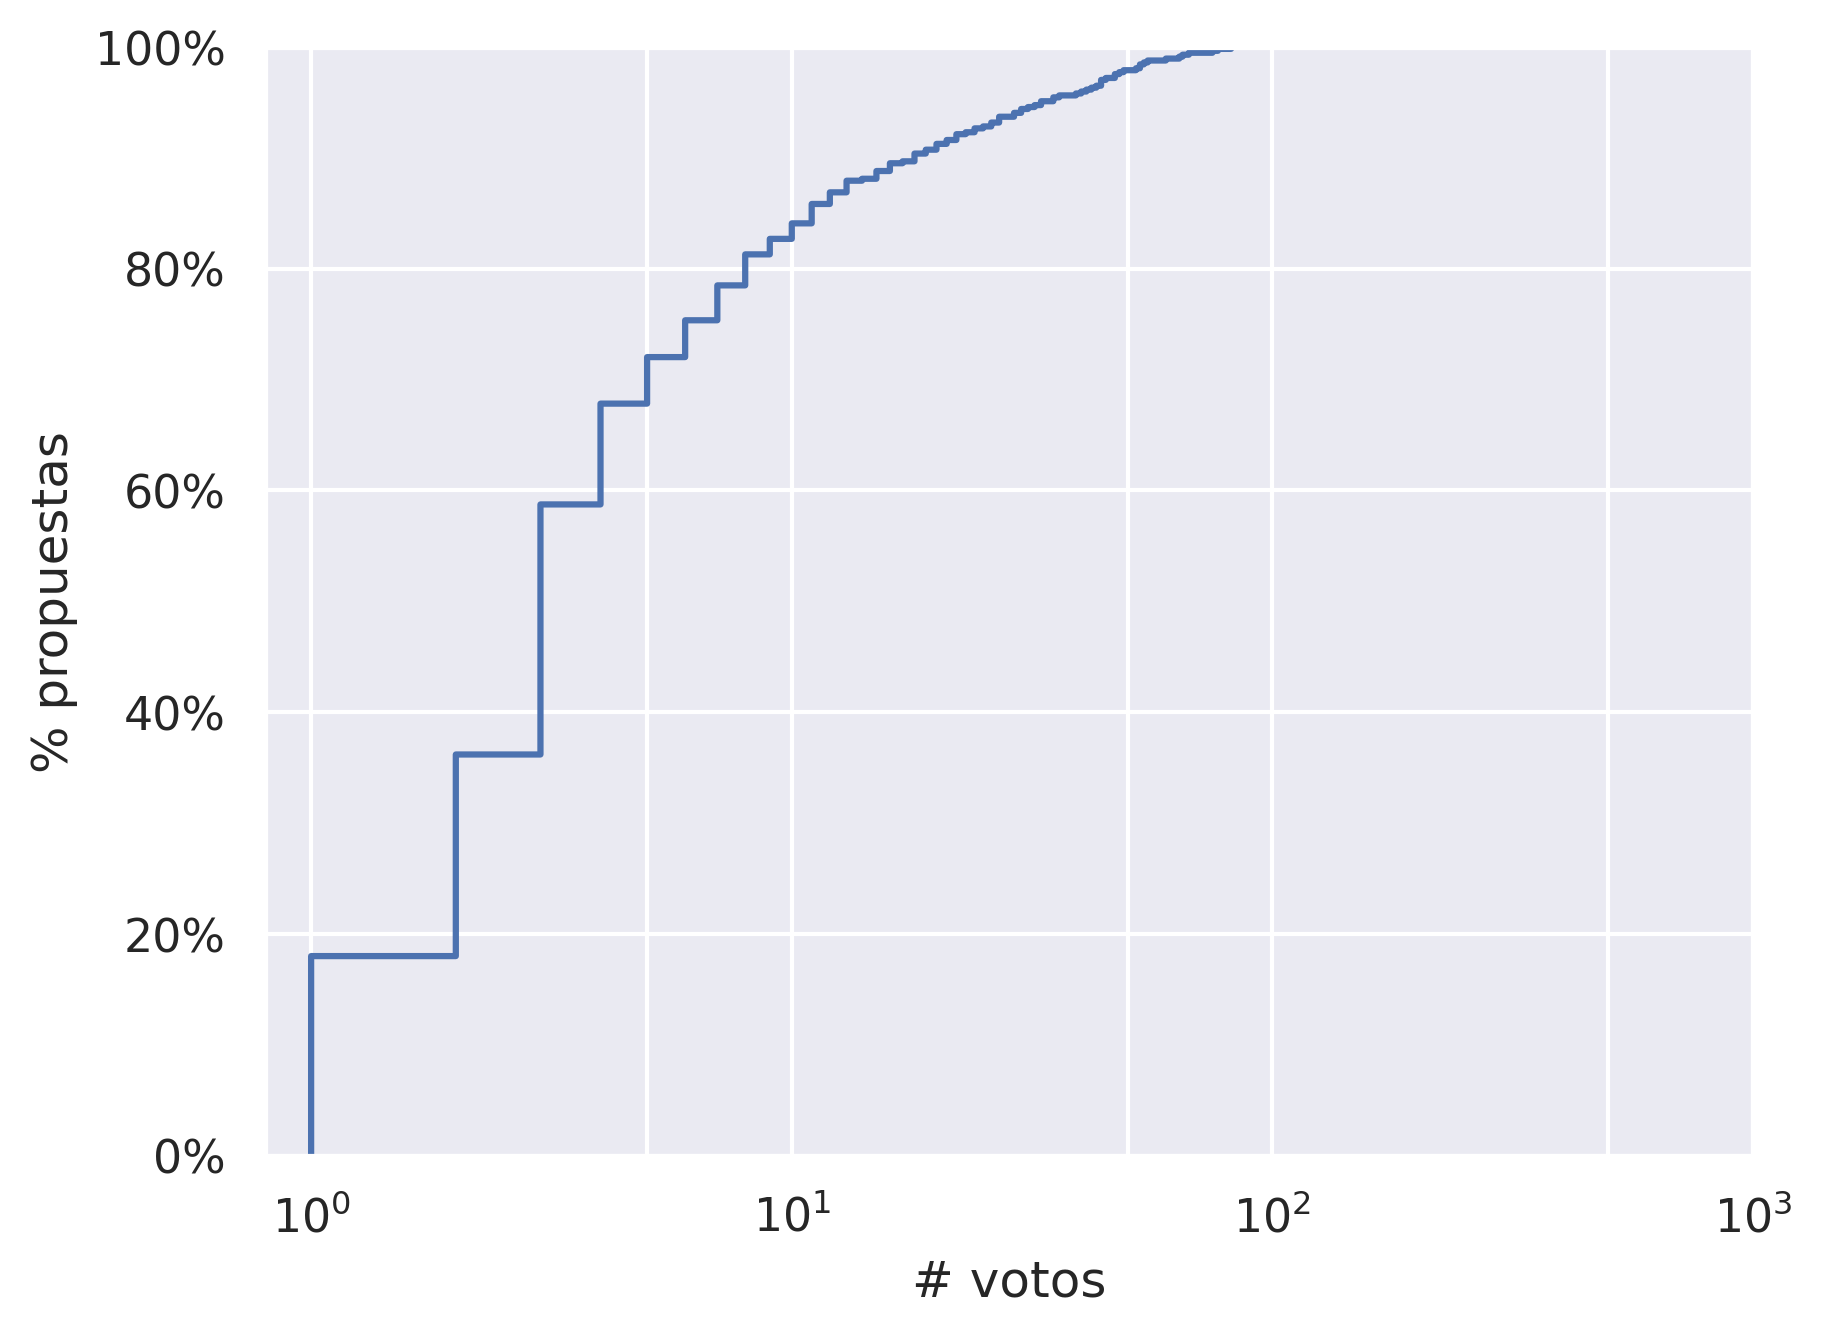

In [8]:
_toplot = dfp['votes_count']
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.xlabel('# votos')
plt.ylabel('% propuestas')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_proposals_{ORG_NAME}.pdf')

count    572.000000
mean       7.256993
std       11.809434
min        1.000000
50%        3.000000
75%        6.000000
90%       18.000000
95%       33.000000
99%       61.160000
max       82.000000
dtype: float64
0


<Axes: ylabel='Proportion'>

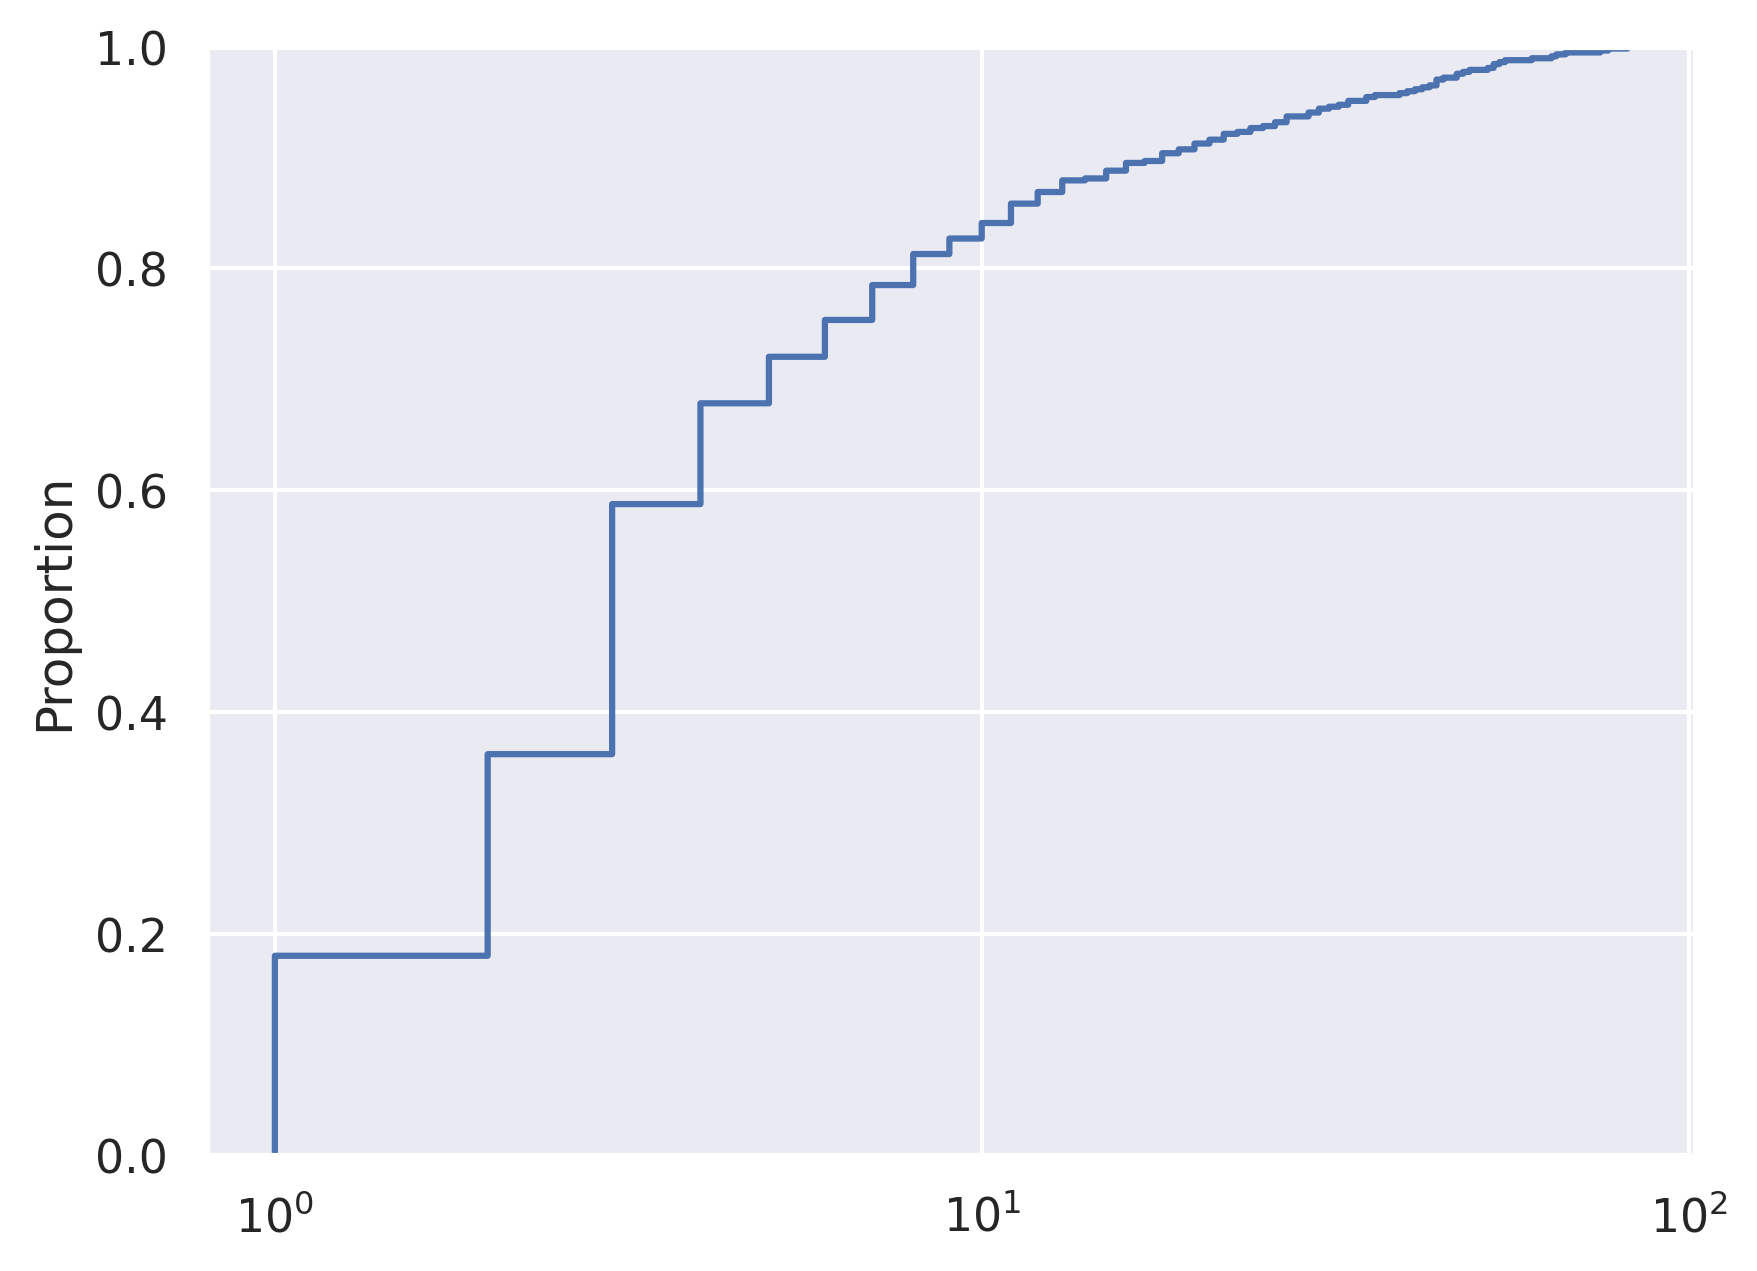

In [9]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )
sns.ecdfplot(_toplot, log_scale=True)

### Usuarios activos

In [10]:
# dfv.set_index('date').sort_index()['voter'].tolist()
# for x in dfv.set_index('date').sort_index()['voter'].items():
#     print(x)

/tmp/ipykernel_3725576/3928196604.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/4151 [00:00<?, ?it/s]

2021-07-22 11:44:39 2023-07-01 00:51:20


Cannot show ipywidgets in text

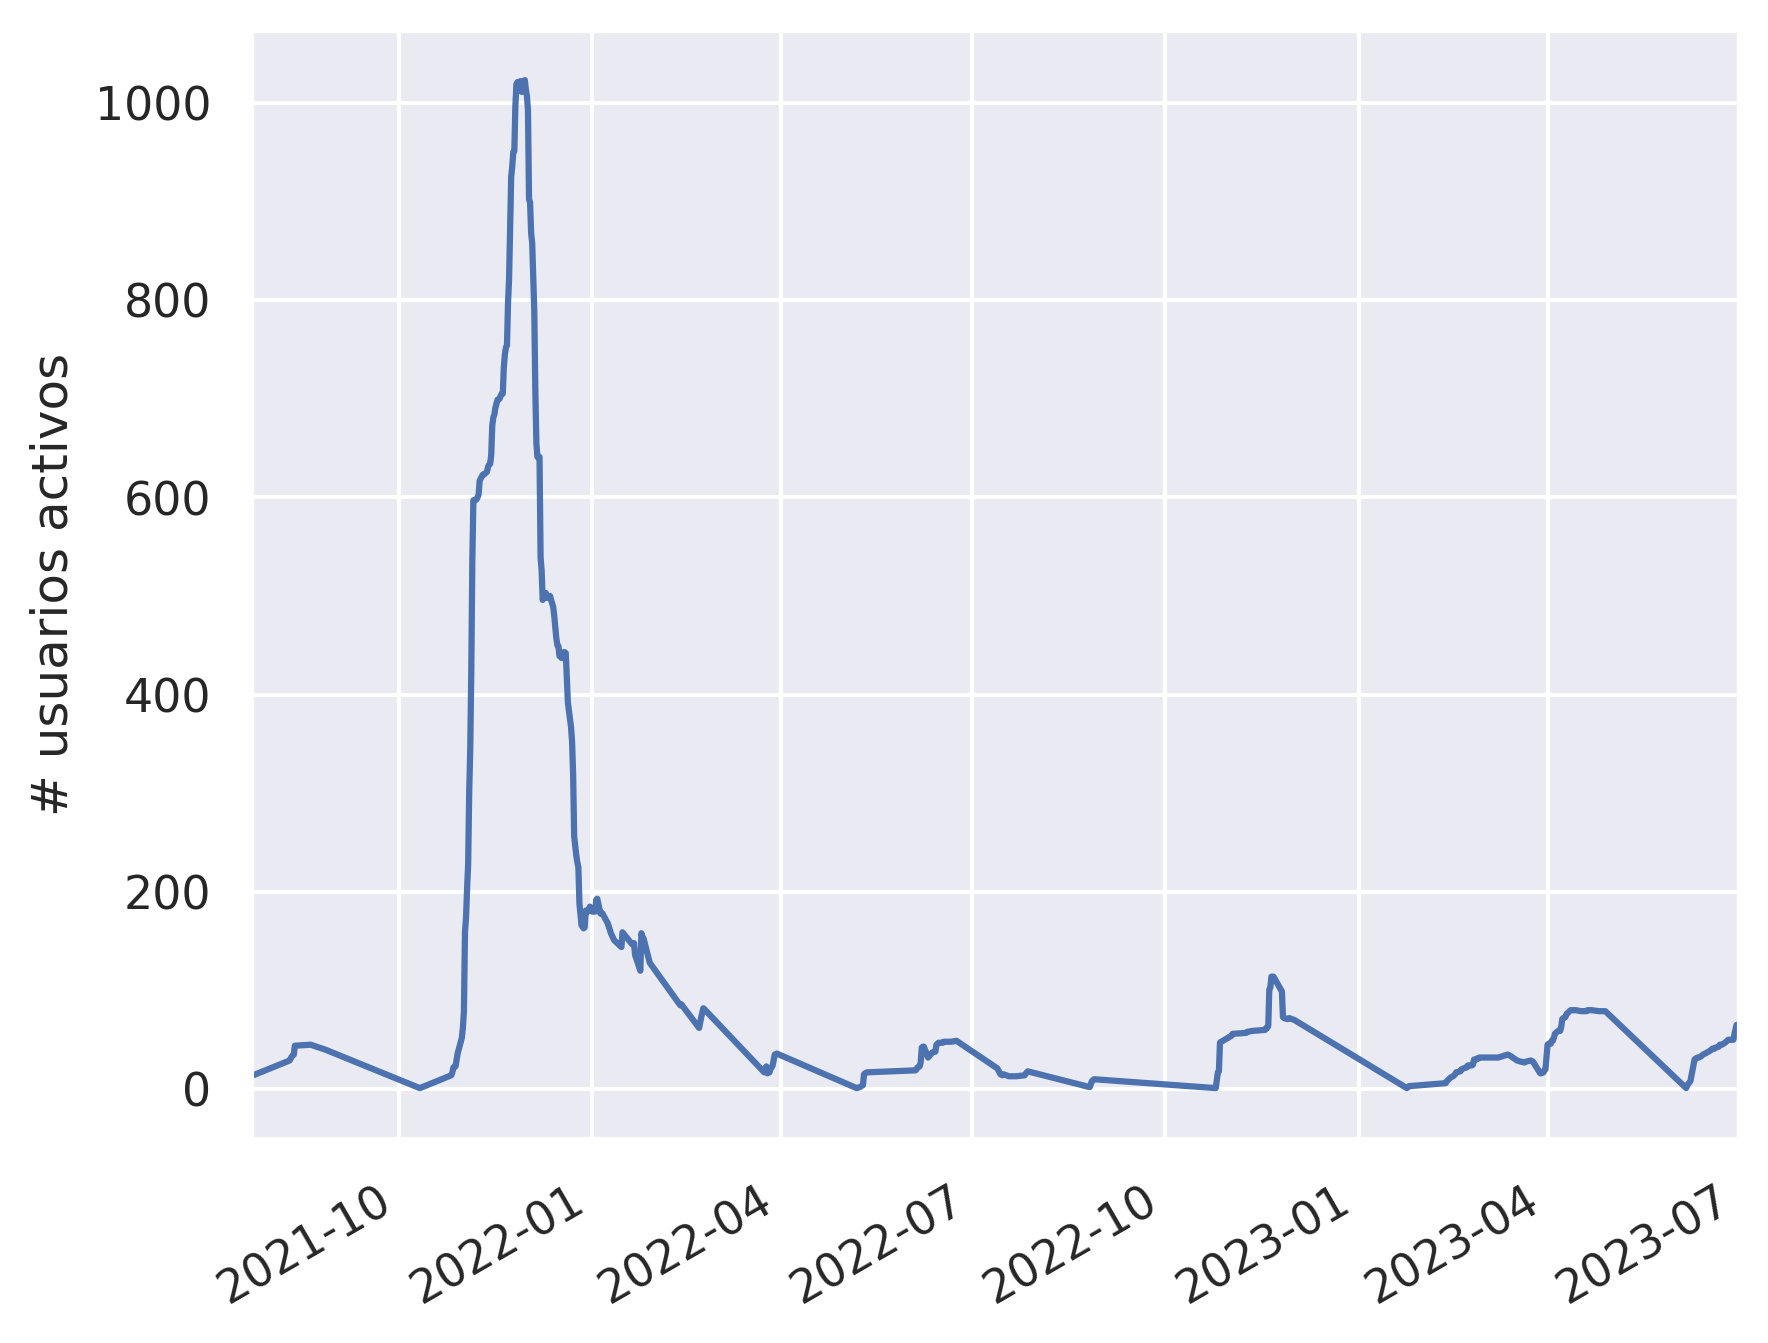

In [11]:
# import numba
from tqdm.autonotebook import tqdm
import rolling
import datetime as dt

tqdm.pandas(total=len(dfv))

# WINDOW_SIZE = '30D'
WINDOW_SIZE = dt.timedelta(days=30)

RESAMPLE_FREQ = '12h'

# @numba.jit(nopython=True)
# def nunique(arr):
#     return len(set(arr))

# Rolling no acepta tipos no númericos en la agregación, por lo que es necesario convertir la categoría a entero
# Por ejemplo, usando el código que le asigna Pandas
# dfv['ucode'] = dfv['voter'].cat.codes
#_cnt = dfv.set_index('date').sort_index().rolling(WINDOW_SIZE)['ucode'].progress_apply(nunique, raw=True).rename('cnt')

# Al final resulta que lo mejor era ir a por la solución O(1)
_voters = dfv.set_index('date').sort_index()['voter'] # .cat.codes
r = tqdm(
    rolling.arithmetic.Nunique(_voters.items(), WINDOW_SIZE, window_type='indexed'),
    total=len(dfv),
)
_cnt = pd.Series(r, index=_voters.index)
# Need to resample or there would be too many points
_cnt = _cnt.resample(RESAMPLE_FREQ).max()

print(dfv['date'].min(), dfv['date'].max())
ax = sns.lineplot(_cnt)
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# usuarios activos')
plt.xlim(dfv['date'].min(), dfv['date'].max())
nbutils.download_matplotlib(ax.figure, f'04c_rolling_voters_{WINDOW_SIZE}_{ORG_NAME}.png')

## Cuando se unen los usuarios

Es decir, cuando votan por primera vez

Cannot show ipywidgets in text

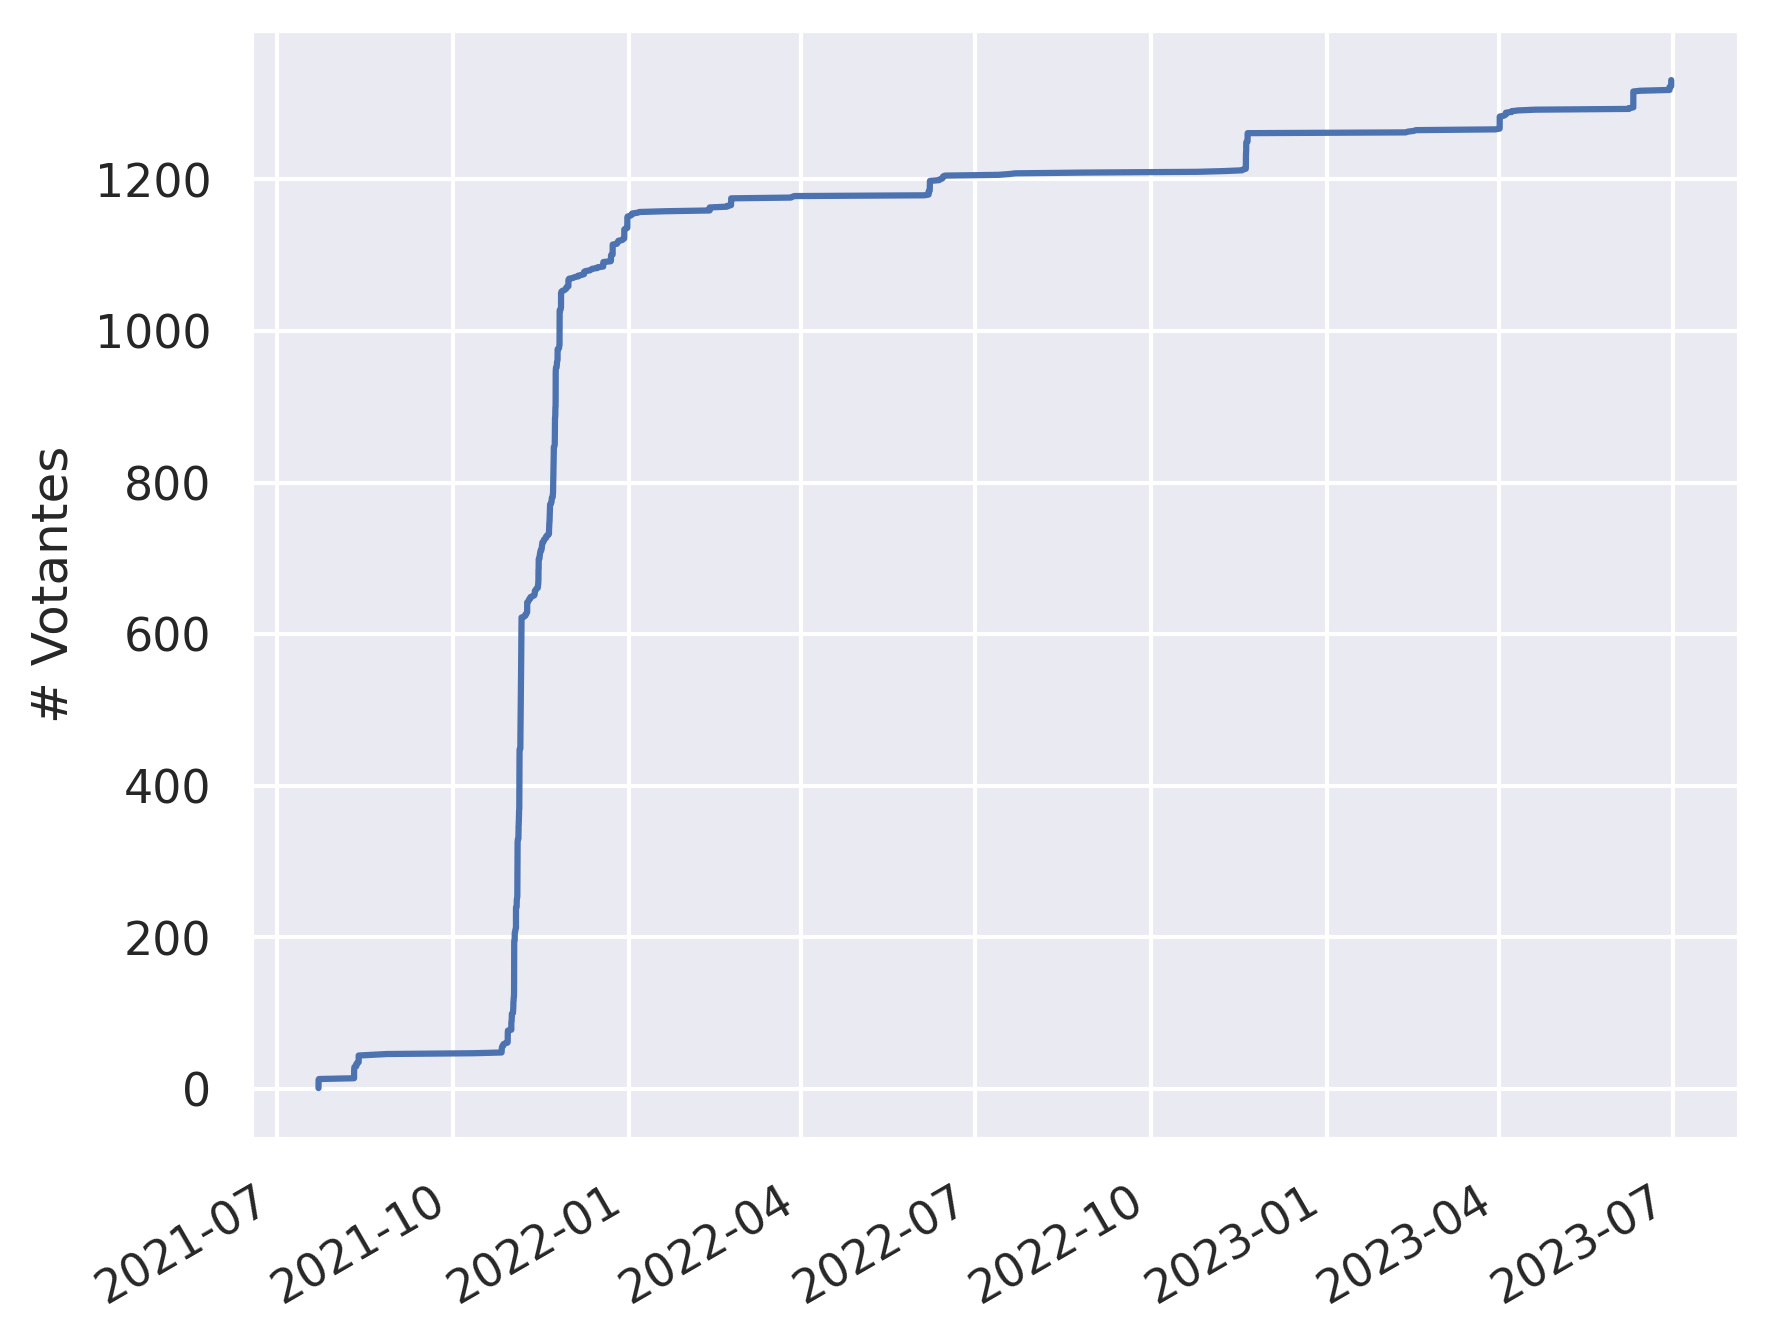

In [12]:
_toplot = dfv.groupby('voter')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Votantes')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_cumcnt_users_{ORG_NAME}.pdf')

## Cuando se crean las propuestas

Cannot show ipywidgets in text

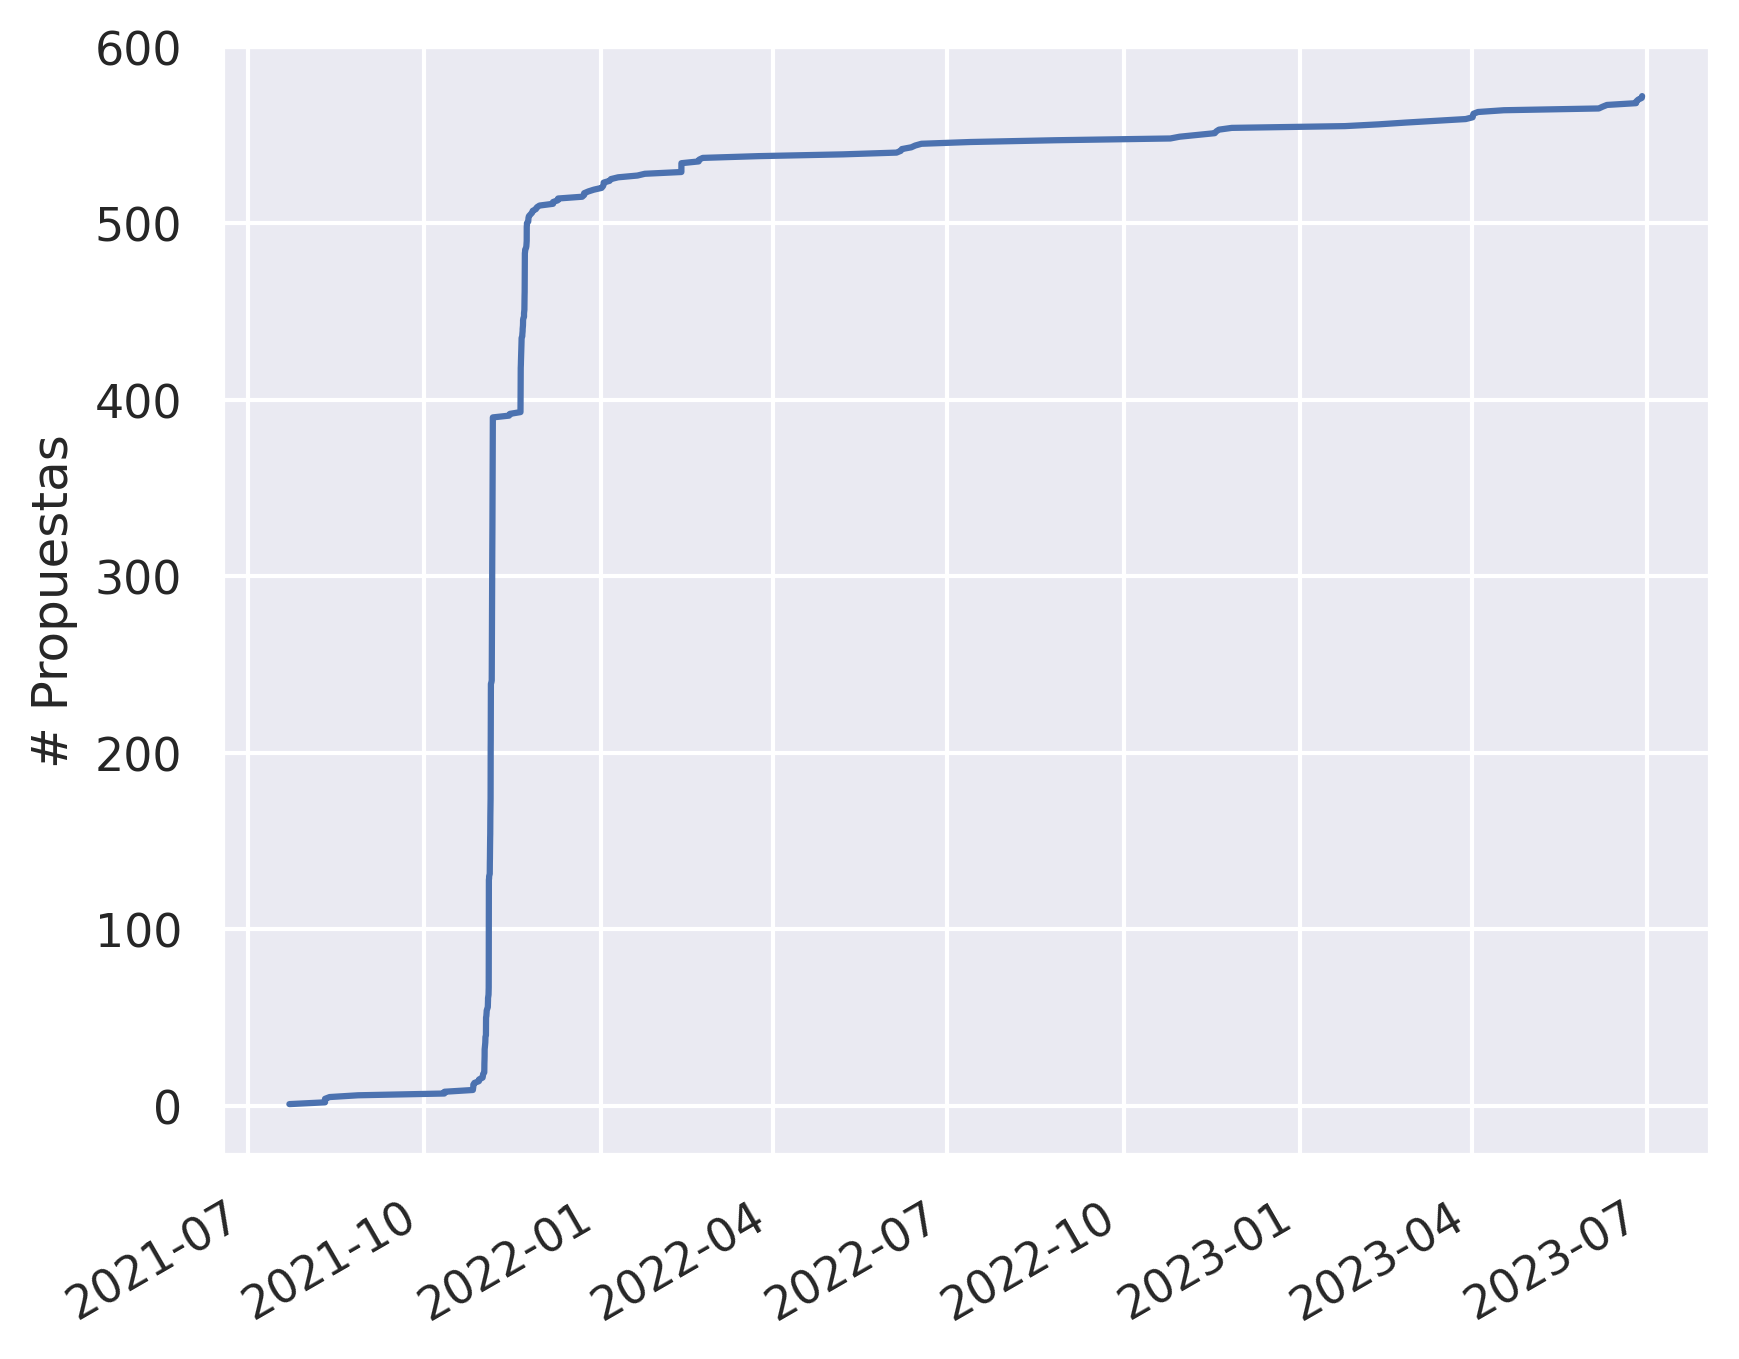

In [13]:
_toplot = dfv.groupby('proposal')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Propuestas')

nbutils.download_matplotlib(ax.figure, f'04c_cumcnt_users_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

<Figure size 1920x1440 with 0 Axes>

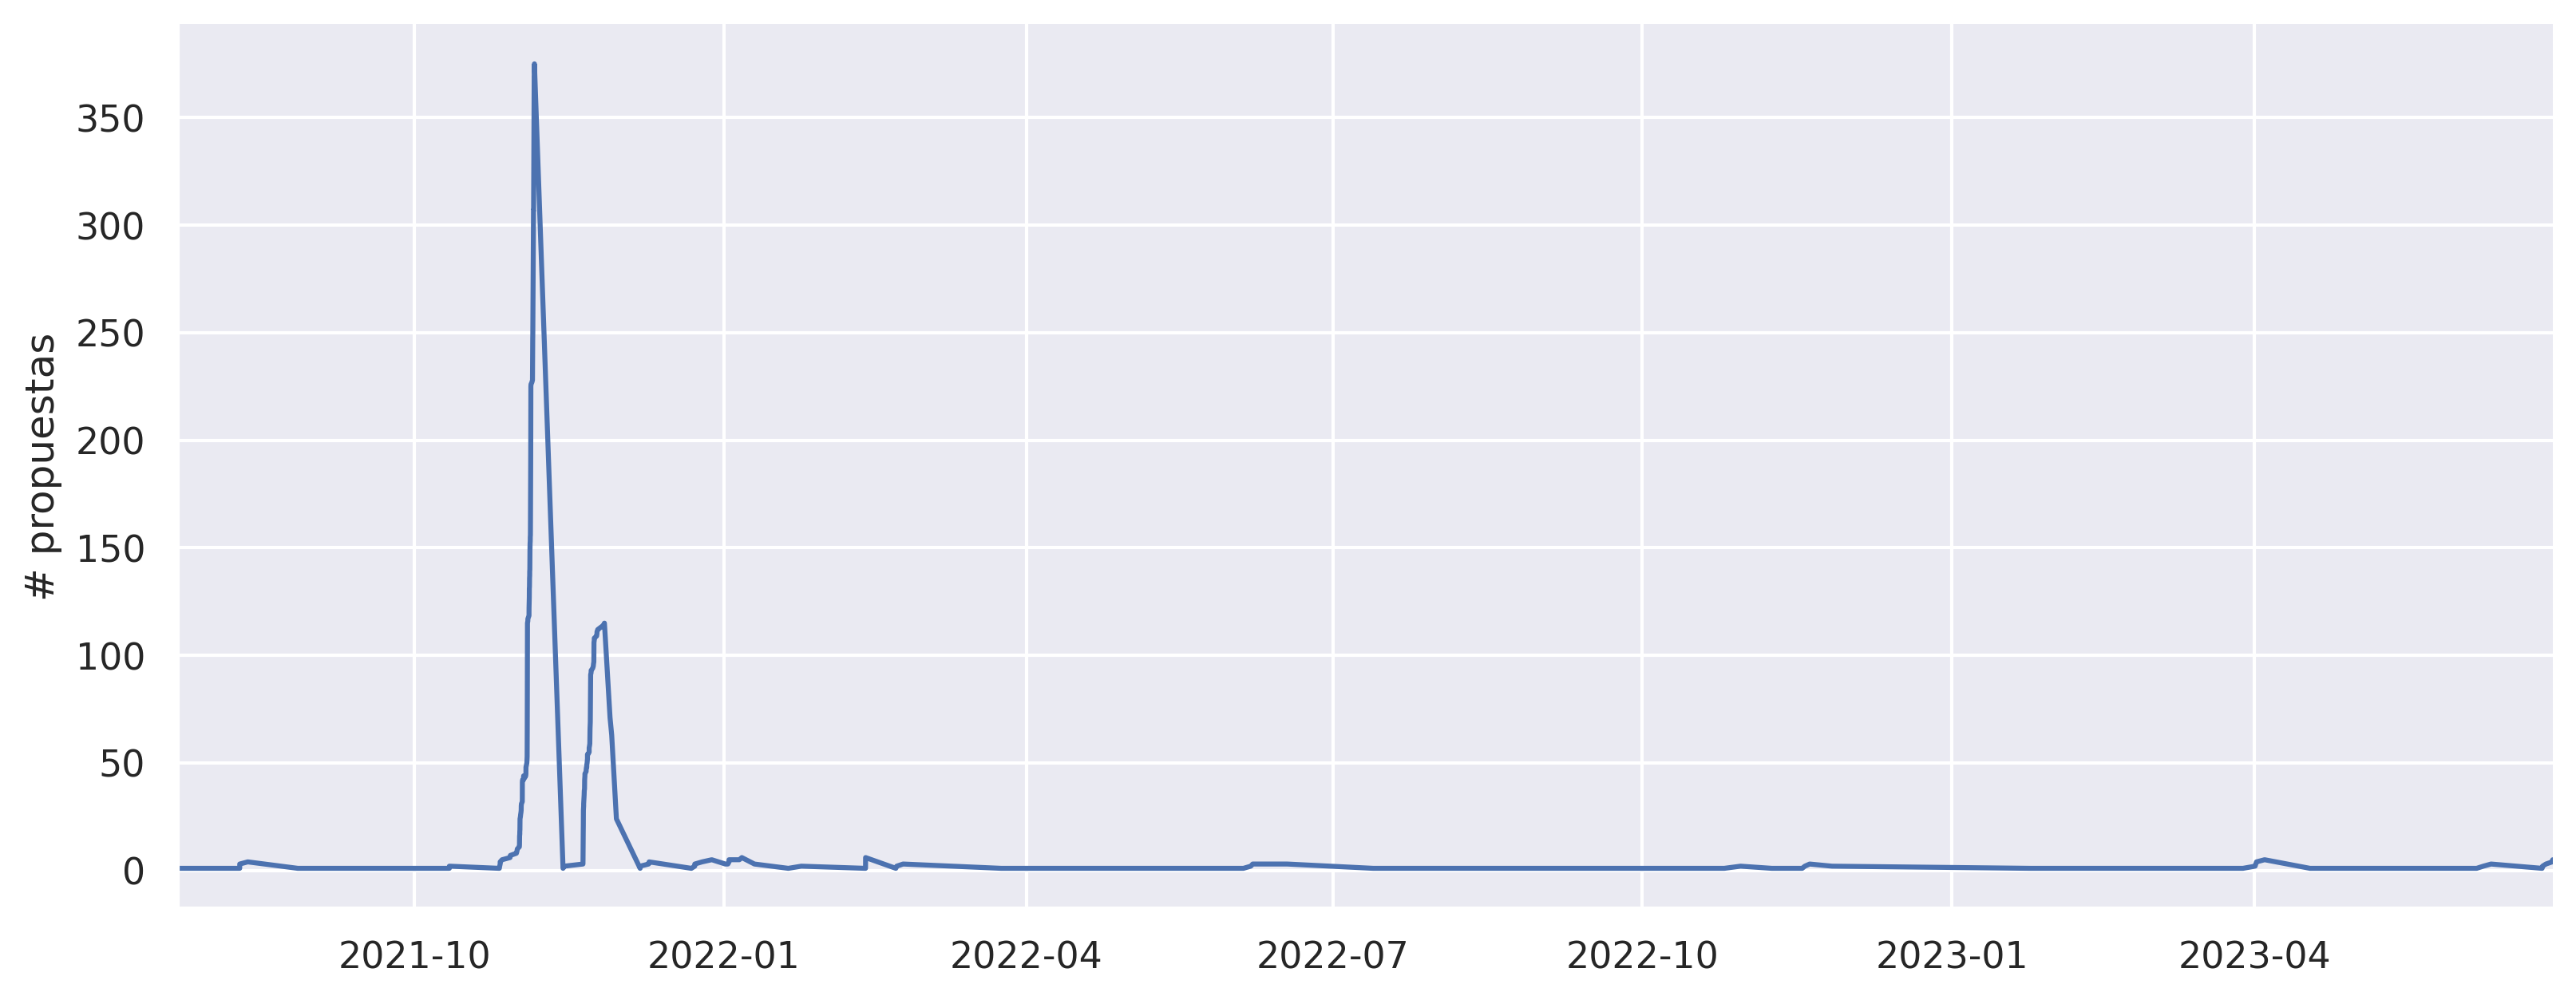

In [14]:
WINDOW_SIZE = '7D'

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=(fs[0]*2, fs[1]))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)

sns.despine()
nbutils.download_matplotlib(ax.figure, f'04c_rolling_proposals_{WINDOW_SIZE}_{ORG_NAME}.pdf')

## Dia de la semana en que se votan las propuestas

> incluso, se podría hacer un heatmap X cuando se lanzan Y cuando se votan y Z (color) la frecuencia
> -- Javi

Vamos, que en esta celda vamos a intentar hacer un HEATMAP donde:
- X: dia de la semana de creación de la propuesta
- Y: dia de la semana de votación
- Z: número de votos

In [15]:
_toplot.to_numpy()

array([[Timestamp('2021-07-22 11:44:39'), 1.0],
       [Timestamp('2021-08-10 02:14:16'), 1.0],
       [Timestamp('2021-08-10 02:27:41'), 2.0],
       ...,
       [Timestamp('2023-06-26 15:19:13'), 3.0],
       [Timestamp('2023-06-28 11:49:40'), 4.0],
       [Timestamp('2023-06-28 15:53:48'), 5.0]], dtype=object)

Text(138.74999999999997, 0.5, 'Día votación')

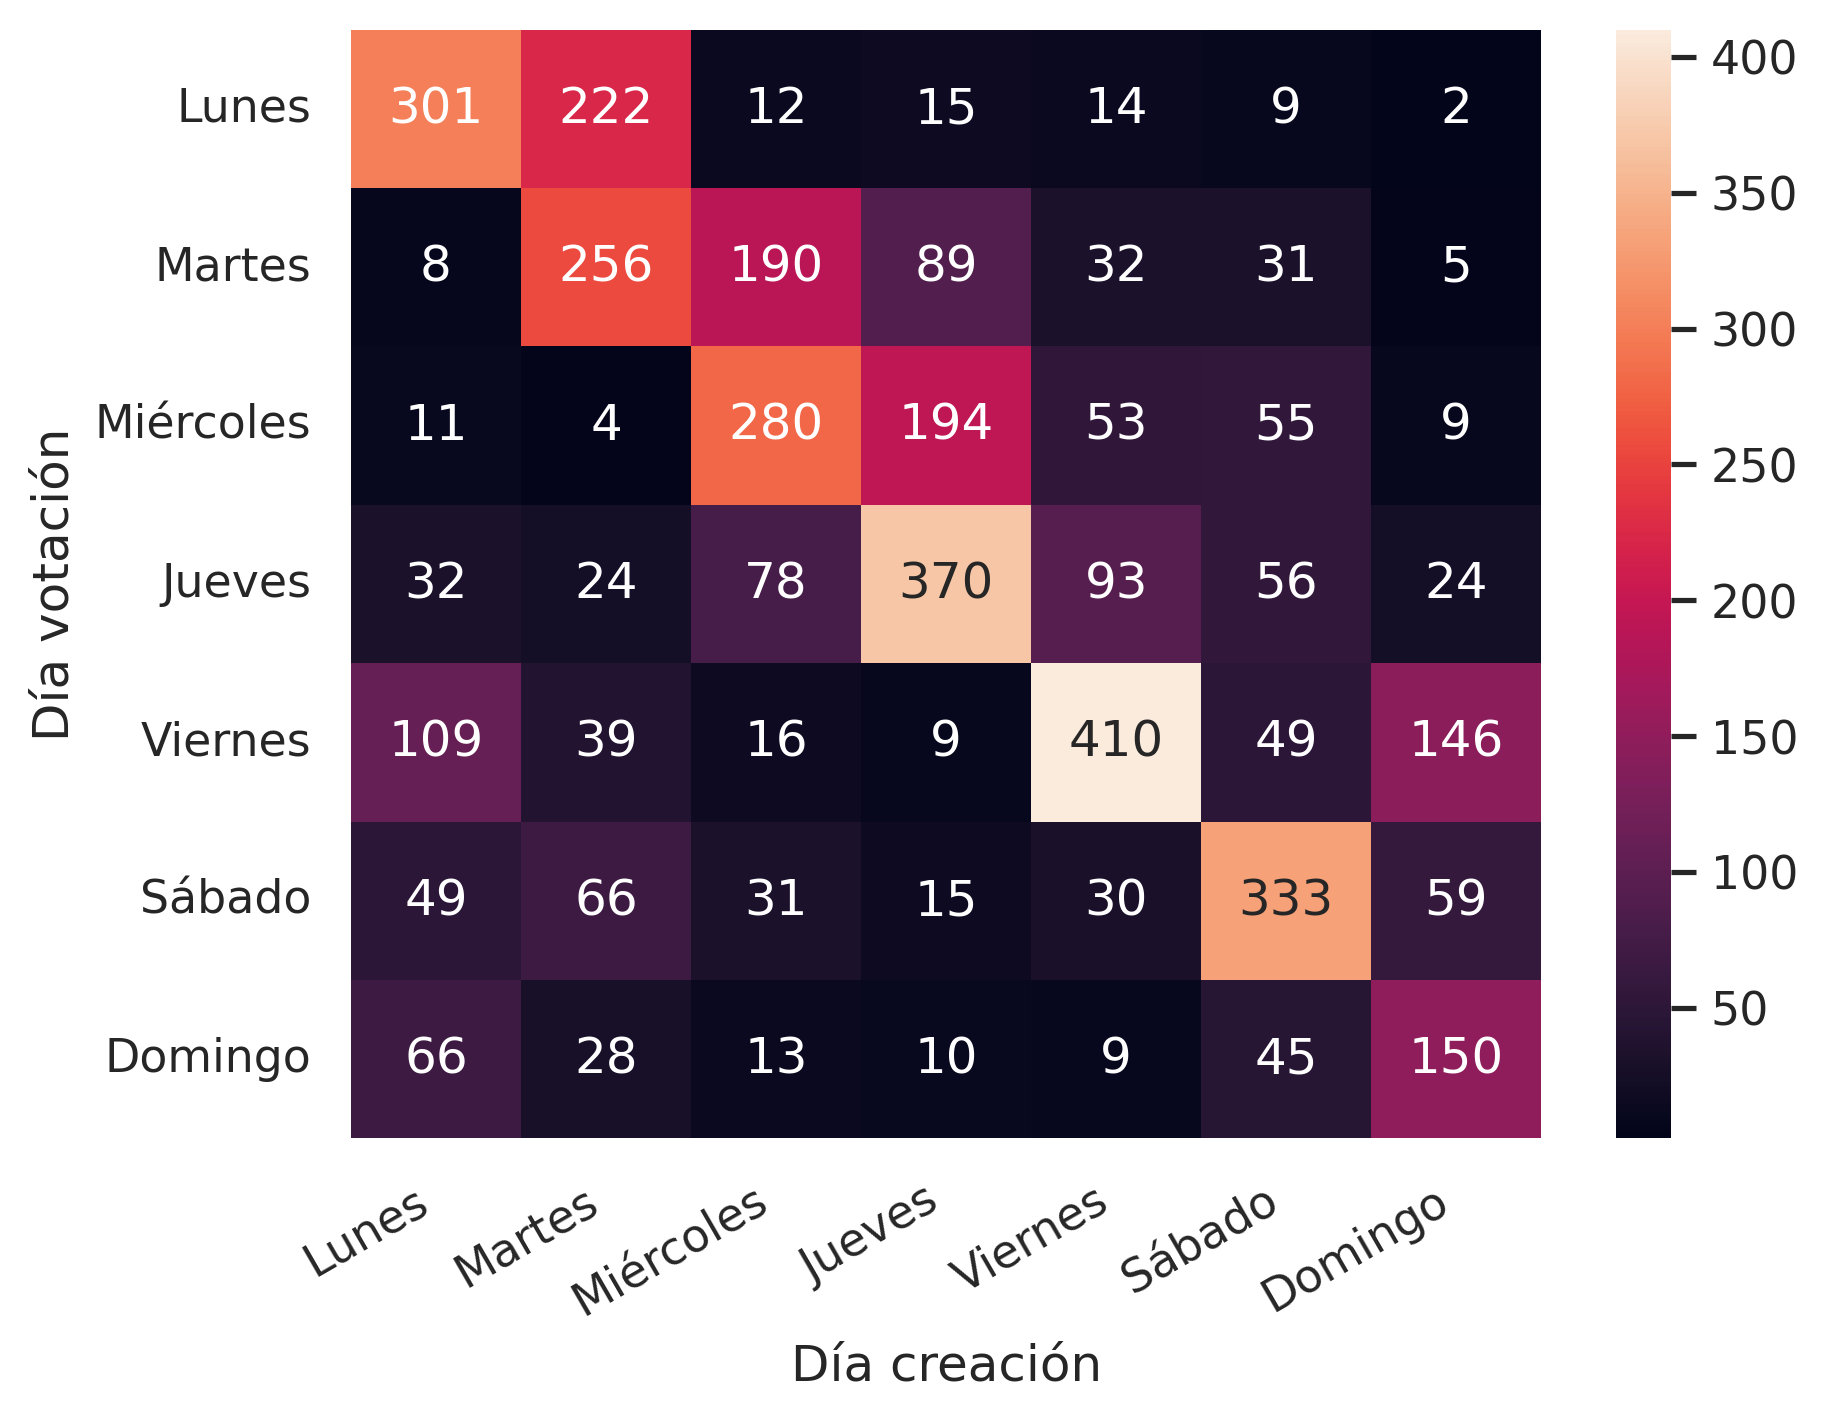

In [16]:
# In pandas, 0 = Monday
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html

spanish_dow = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes', 
    5: 'Sábado',
    6: 'Domingo',
}

_dfvp = dfv.merge(dfp['date'].rename('proposal_date'), left_on='proposal', right_index=True)
_dfvp['date_dow'] = _dfvp['date'].dt.day_of_week
_dfvp['proposal_date_dow'] = _dfvp['proposal_date'].dt.dayofweek
# sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
_toplot = pd.crosstab(_dfvp['proposal_date_dow'], _dfvp['date_dow']).rename(index=spanish_dow, columns=spanish_dow)

sns.heatmap(_toplot, annot=True, fmt='g')
plt.xticks(rotation=30, ha='right')

plt.xlabel('Día creación')
plt.ylabel('Día votación')

Cannot show ipywidgets in text

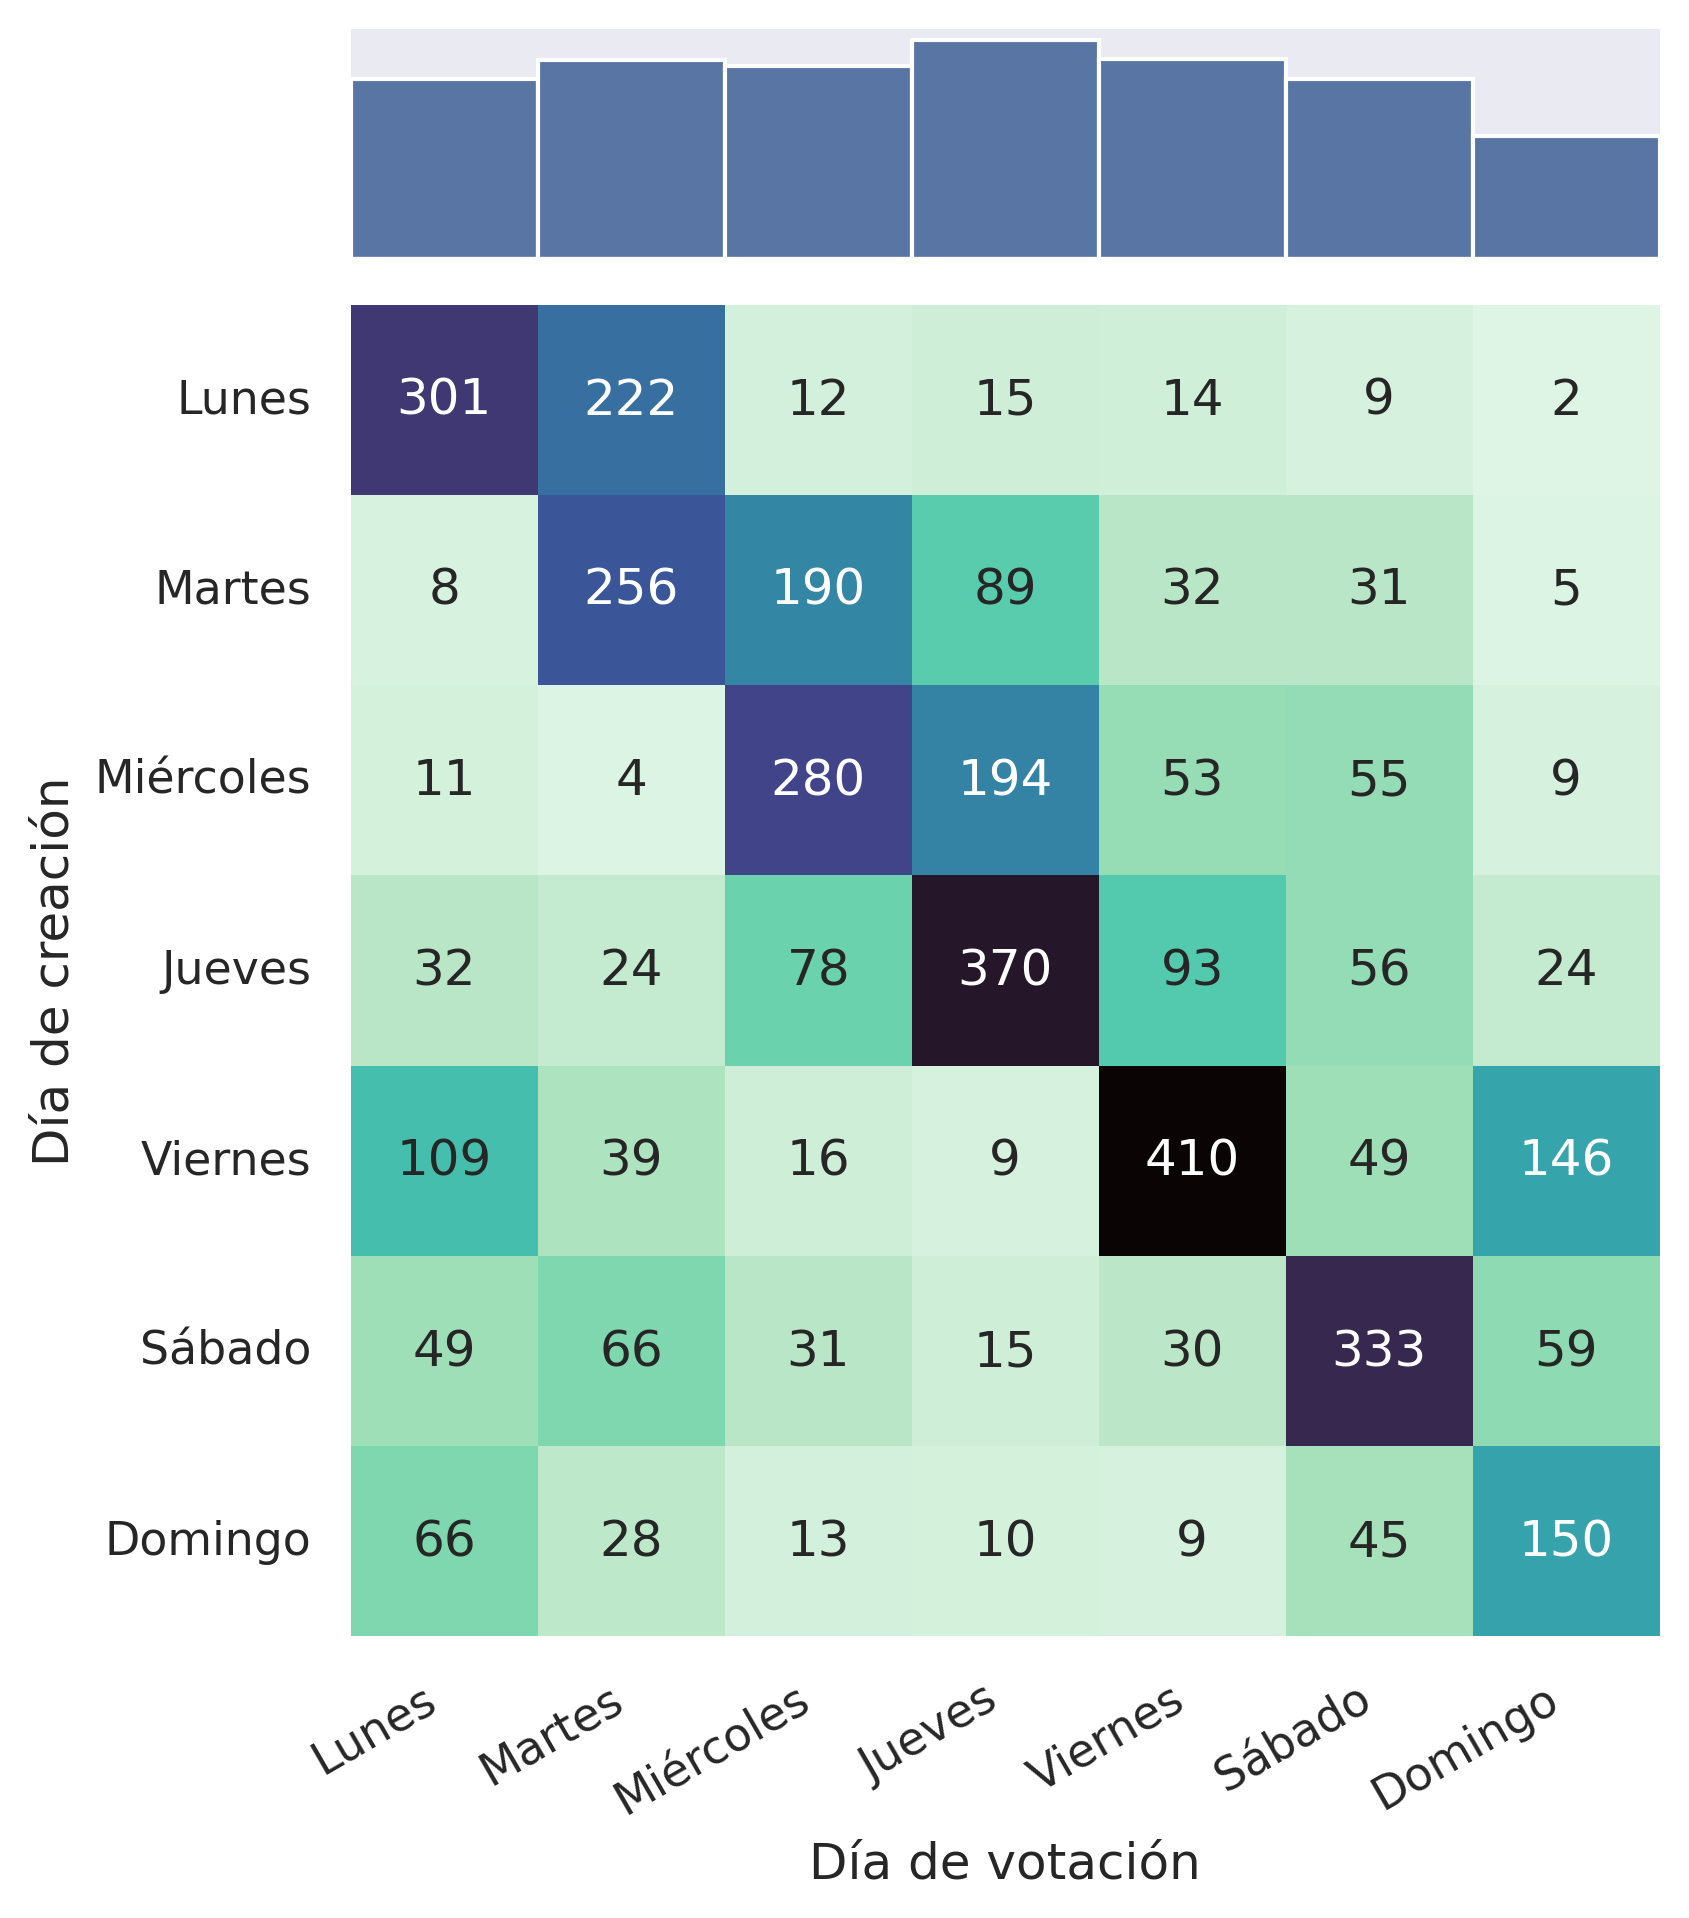

In [17]:
# _toplot = pd.crosstab(...)
HIDE_MARGINAL_Y = True

grid = sns.JointGrid()

sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt='g', cmap='mako_r')
sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=1)
sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=1)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)
grid.ax_marg_y.axis('off')

if HIDE_MARGINAL_Y:
    plt.delaxes(grid.ax_marg_y)

grid.ax_joint.set_xticklabels(grid.ax_joint.get_xticklabels(), rotation=30, ha='right')
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Día de votación')
grid.ax_joint.set_ylabel('Día de creación')

nbutils.download_matplotlib(grid, f'04c_heatmap_proposals_{ORG_NAME}.pdf')

<Axes: xlabel='proposal_date_dow', ylabel='count'>

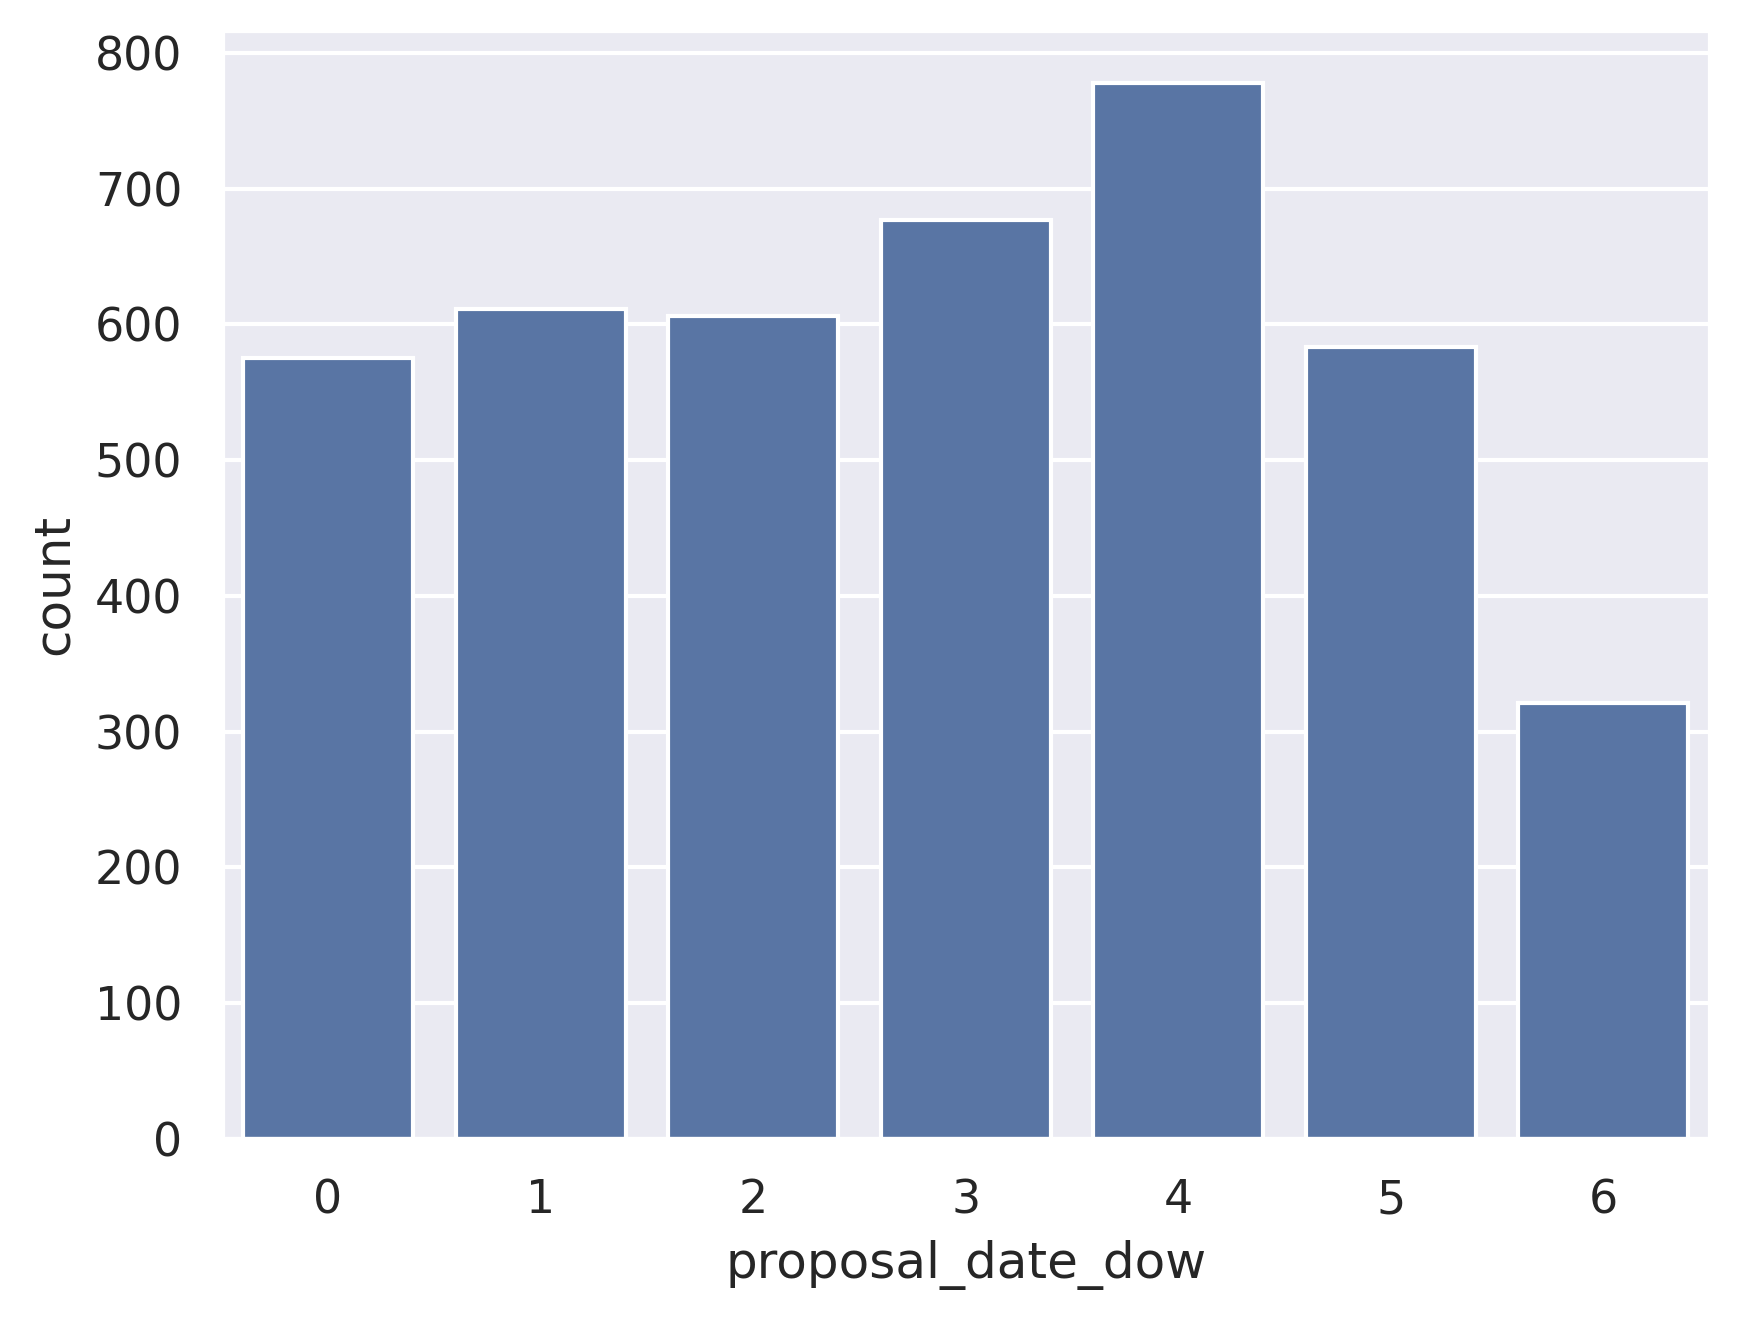

In [18]:
sns.countplot(_dfvp, x='proposal_date_dow')

<Axes: xlabel='count', ylabel='date_dow'>

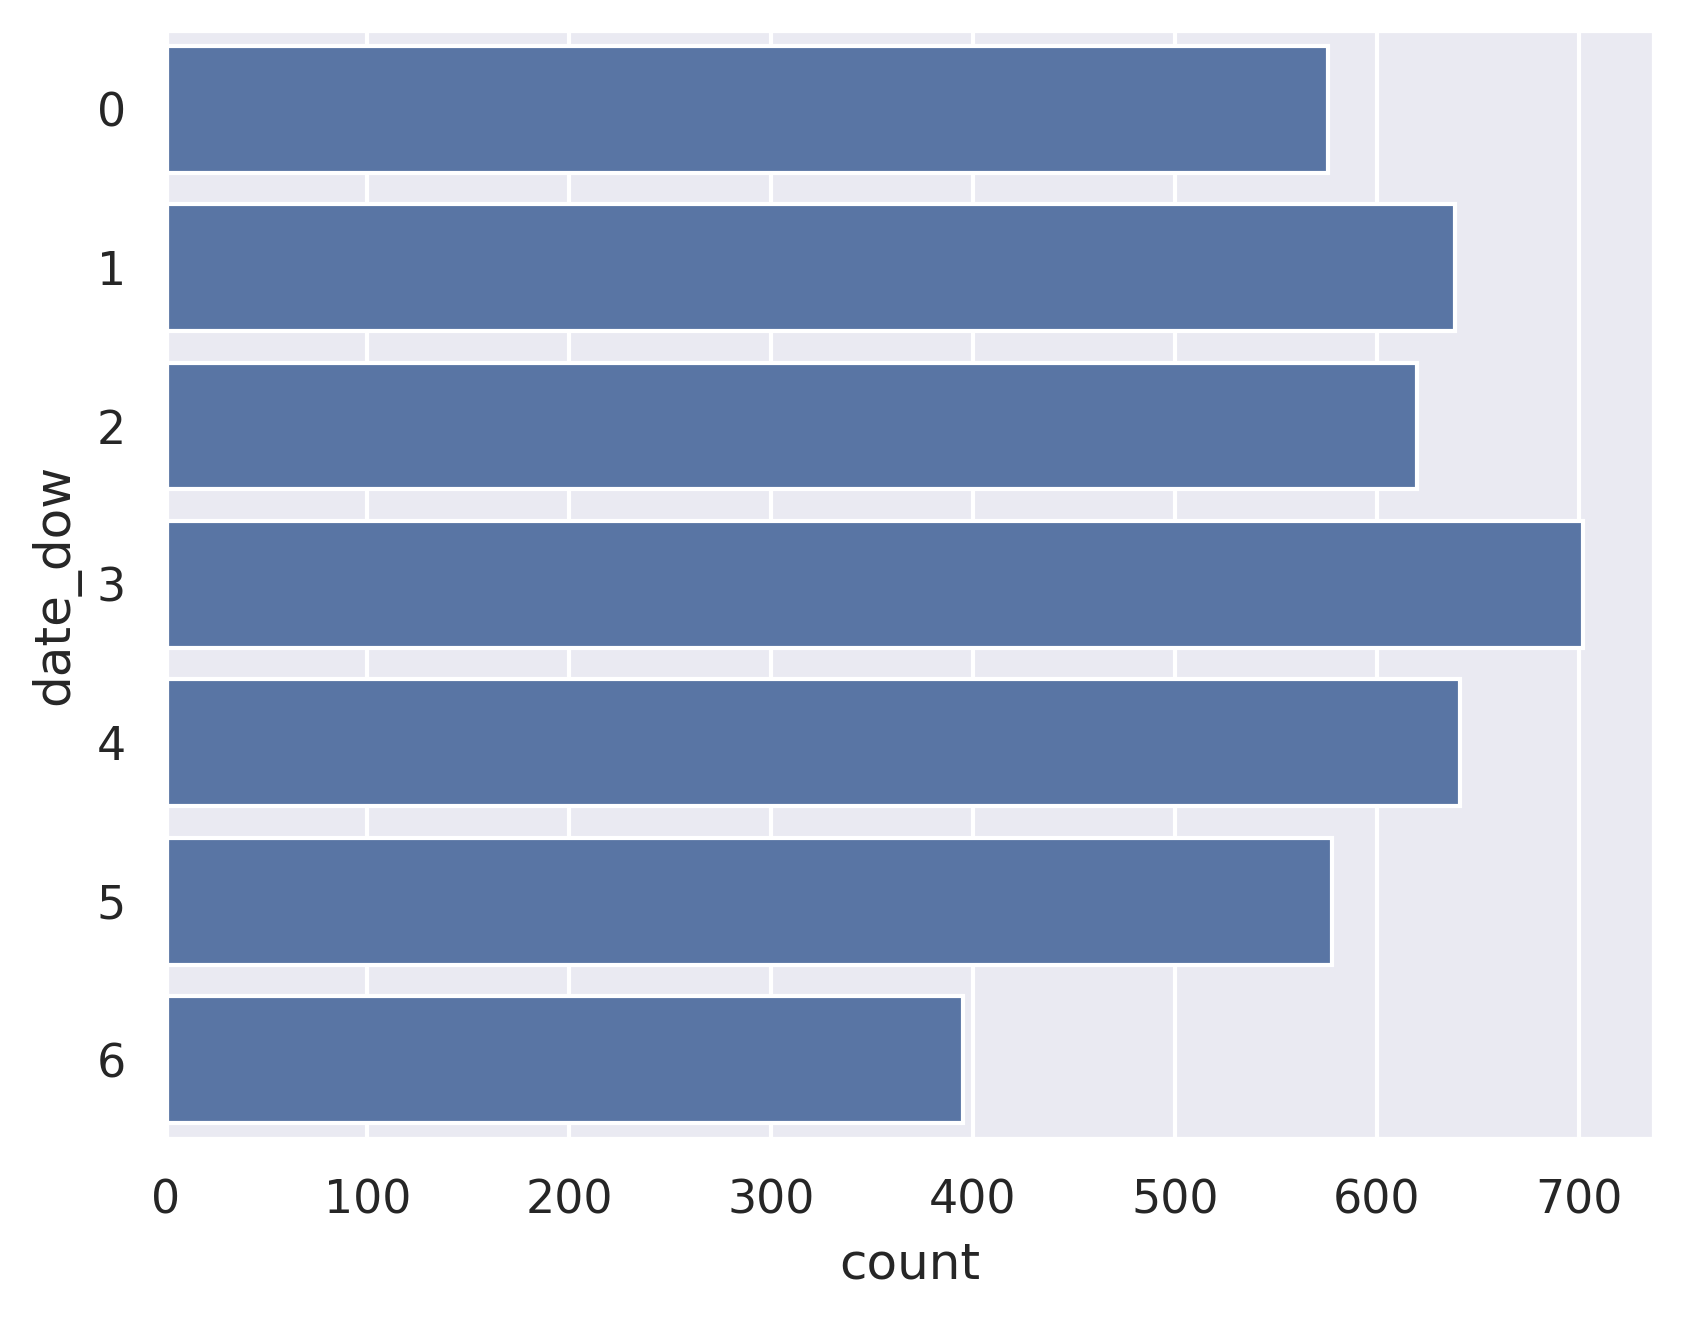

In [19]:
sns.countplot(_dfvp, y='date_dow')

## Dia de la semana en que se crean las propuestas

Friday       159
Thursday     117
Wednesday     89
Monday        71
Saturday      64
Tuesday       42
Sunday        30
Name: start, dtype: int64


/tmp/ipykernel_3725576/3121848446.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(spanish_dow.values(), rotation=30, ha='right')


Cannot show ipywidgets in text

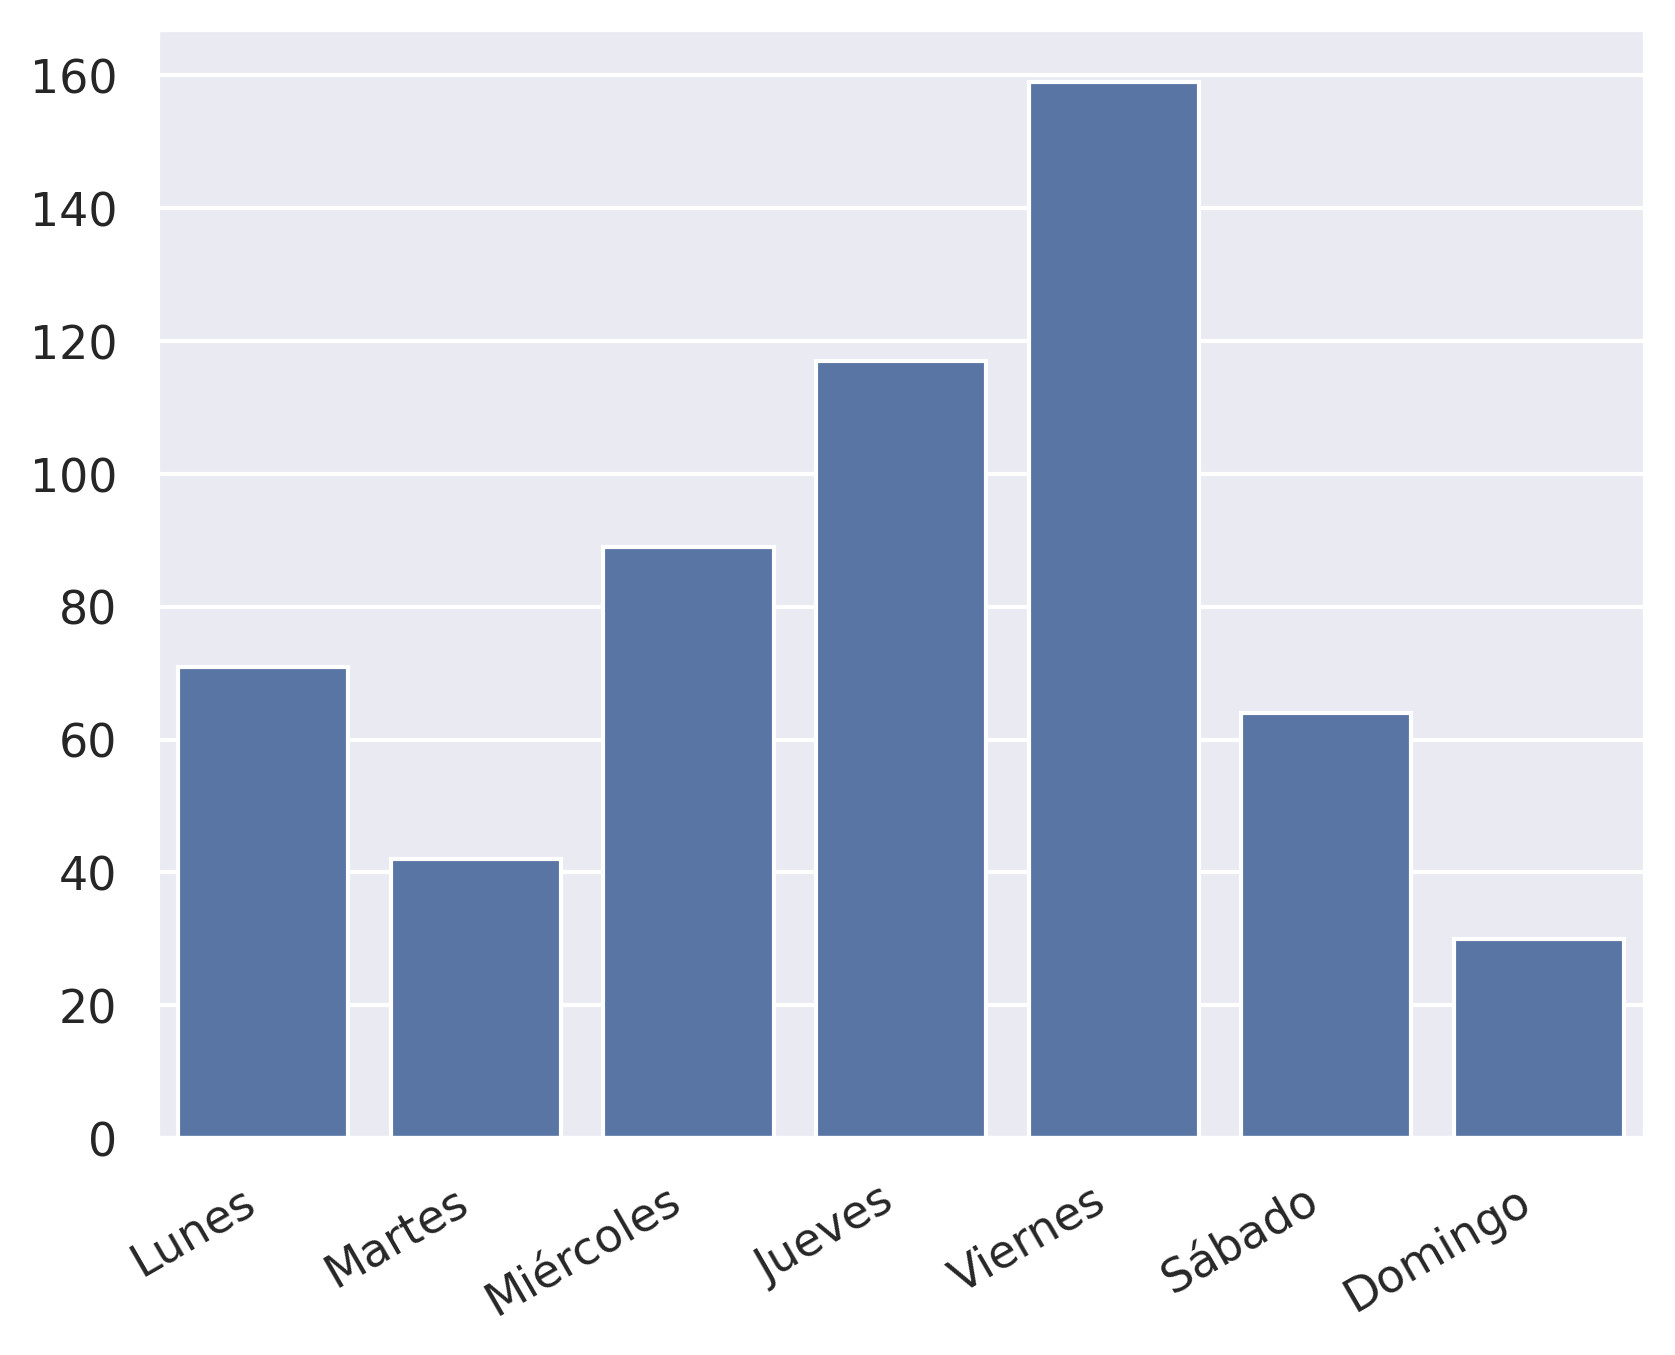

In [20]:
ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_xticklabels(spanish_dow.values(), rotation=30, ha='right')
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
plt.xlabel('')
plt.ylabel('')
print(dfp['start'].dt.day_name().value_counts())
nbutils.download_matplotlib(ax.figure, f'04_creation_dow_{ORG_NAME}.pdf')

## Suelen votarse las propuestas al principio o al final

In [21]:
def proposal_histogram(proposal):
    p = dfp.loc[proposal]
    _aux = dfv[dfv["proposal"] == proposal][['platform', 'name', 'date']].copy().sort_values('date')
    first_vote = p['start']
    last_vote = p['end']
    print(p['start'], p['end'], p['end'] - p['start'])
    _aux['date_rel'] = (_aux['date'] - p['start']) / (p['end'] - p['start'])
    # sns.ecdfplot(_aux['date_rel'])
    ax = sns.histplot(_aux['date_rel'])
    ax.set_title(f"Histograma de tiempo de los votos en la propuesta {proposal}")
    return ax

# proposal_histogram(proposal = "b86aa059-3d31-5d41-a472-70962816f779")

## Ahora para TODOS los votos

Cuidado que este grafo puede estar sesgado por una sola propuesta

In [22]:
dfp

,platform,name,platform_deployment,deployment,platform_proposal,author,date,title,description,start,end,votes_count
id,,,,,,,,,,,,
fc7f3d1e-19a3-561b-a4ff-41a4bb31b6d1,snapshot,HUWA-DAO,huwacoin.eth,7b930871-5e1b-5efe-af9a-dc5413460604,0xd83678982135cf021436e4bb2a014237a5c3f0d47baa...,0x75a65fbe14f0ea664c4c189a62f2350ef7e95e1b,2021-11-20 04:19:00,十一地主是个很不错的小伙子,,2021-11-20 04:20:00,2022-01-01 04:00:00,1
dda987b6-2711-5d07-880a-20d9e2d4265a,snapshot,HUWA-DAO,huwacoin.eth,7b930871-5e1b-5efe-af9a-dc5413460604,0xf3f6e5079b7b88ea0054949ede6489a181379f429fe5...,0xd3be44f470ec96faef322f004aefc32dfff76119,2021-11-05 13:49:05,怎么才能获得最准确的消息？,行情咨询,2021-11-05 04:00:00,2021-11-07 04:00:00,1
7e83e5ac-da7d-5034-ae3f-ca2ff07a2785,snapshot,HUWA-DAO,huwacoin.eth,7b930871-5e1b-5efe-af9a-dc5413460604,0x16633d877daeb8ae59049181ebd3b8fe365570c23600...,0xcb0a07c8ebf6da7e7d15b0889f572db1f1698607,2021-11-05 03:00:47,你是否看好隐私币？,,2021-11-05 03:00:00,2021-11-30 04:00:00,1
8388bd28-181f-5b25-957b-8bdeab5ff1da,snapshot,HUWA-DAO,huwacoin.eth,7b930871-5e1b-5efe-af9a-dc5413460604,0x097e9f9e797ec85a9992bcb27057e1ee5988d34ef713...,0x9a94c22bc24a49ae3a095450ca7a7b9b4ac810c3,2021-11-04 15:16:22,什么手机好？,,2021-11-04 04:00:00,2021-11-05 04:00:00,1
ffab6d0d-f4dd-5bd5-8ead-864331c4b954,snapshot,HUWA-DAO,huwacoin.eth,7b930871-5e1b-5efe-af9a-dc5413460604,0xcdfd5a702bd7896d513d7e649d4db75387cd1084dc56...,0x9d5ef6a986cc530488d010bd308eda627db7bc8a,2021-11-04 15:05:11,脸书为啥要改名字？,脸书,2021-11-04 04:00:00,2021-11-06 04:00:00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5e8e2f3f-57d6-557b-985e-8f970be3a054,snapshot,HUWA-DAO,huwacoin.eth,7b930871-5e1b-5efe-af9a-dc5413460604,0xc5fe6f4a36156e059e14e9a5614b0838905ea7376f40...,0x7775db07846dcbbe4b95284f6aa1e6c623301613,2021-11-05 14:25:50,十一更看好BTC还是ETH？,,2021-11-05 04:00:00,2021-11-09 04:00:00,2
3b32d3d2-fdfc-58d4-b61b-4fde9e595580,snapshot,HUWA-DAO,huwacoin.eth,7b930871-5e1b-5efe-af9a-dc5413460604,0xe71143708eaef0e9537053c02a1b178c44d52222e7cd...,0x335a2bff021dc05bf1636b466c6467994e18fd42,2021-11-05 14:09:08,以太坊会达到10000美元吗？,以太坊,2021-11-05 04:00:00,2021-11-07 04:00:00,2
7dd49710-c969-5a9c-b983-2730c29ec5da,snapshot,HUWA-DAO,huwacoin.eth,7b930871-5e1b-5efe-af9a-dc5413460604,0x4083f68c80ee8ea44b83da72a9a7577b3d13ebf7aa63...,0x7110d783168fd1035ef1c417a31cf9c57fee0787,2021-11-05 14:06:38,BNB这是要破新高吗？,BNB,2021-11-05 04:00:00,2021-11-07 04:00:00,2


Text(0.5, 1.0, 'Histograma de todos los votos realizados en HUWA-DAO')

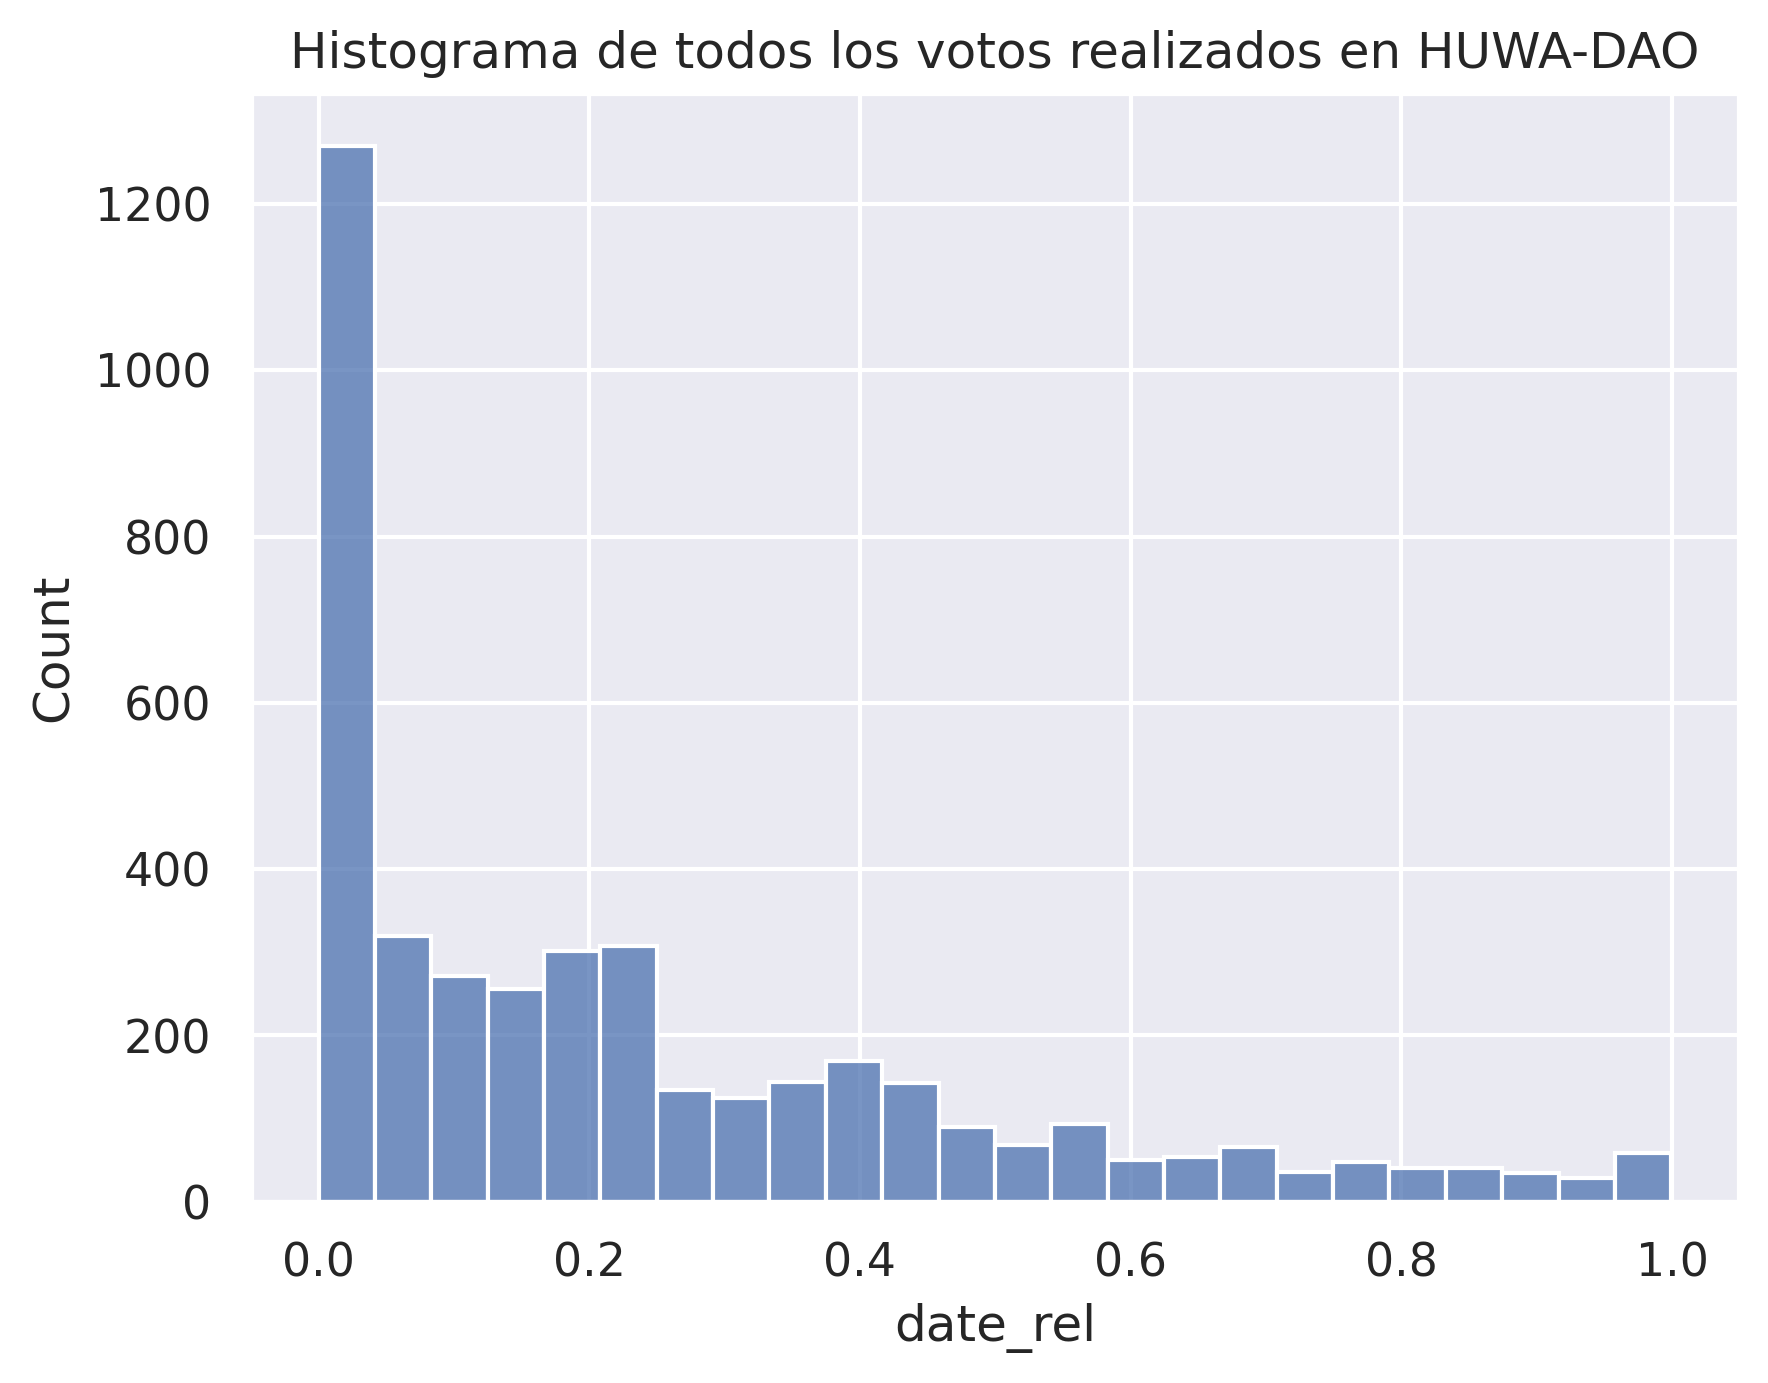

In [23]:
_dfv = dfv[['platform', 'name', 'proposal', 'date']].merge(dfp[['start', 'end']], left_on='proposal', right_index=True).sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
ax = sns.histplot(_dfv, x='date_rel')
ax.set_title(f"Histograma de todos los votos realizados en {ORG_NAME}")

In [24]:
_dfv[['date_rel']].describe(percentiles=[.1,.25,.5,.75,.78,.8])

,date_rel
count,4151.000000
mean,0.234869
std,0.248639
min,0.000007
10%,0.005008
25%,0.031613
50%,0.159019
75%,0.367636
78%,0.397237
80%,0.424432


### Cuando son los votos (histograma distribución en tiempo de TODOS los votos)

Vamos a intentar calcular la frecuencia relativa acumulada

In [25]:
rel = (1 / _dfv.groupby('proposal').size()).rename('freq')
_dfv2 = _dfv.join(rel, on='proposal')
_dfv2['cumfreq'] = _dfv2.groupby('proposal')['freq'].cumsum()
_dfv2

,platform,name,proposal,date,start,end,date_rel,freq,cumfreq
1512,snapshot,HUWA-DAO,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:44:39,2021-07-21 04:00:00,2021-07-31 04:00:00,0.132267,0.076923,0.076923
1511,snapshot,HUWA-DAO,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:48:19,2021-07-21 04:00:00,2021-07-31 04:00:00,0.132522,0.076923,0.153846
1510,snapshot,HUWA-DAO,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:48:38,2021-07-21 04:00:00,2021-07-31 04:00:00,0.132544,0.076923,0.230769
1509,snapshot,HUWA-DAO,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:53:23,2021-07-21 04:00:00,2021-07-31 04:00:00,0.132874,0.076923,0.307692
1508,snapshot,HUWA-DAO,7f78eca6-a122-5074-ad86-268642177a4b,2021-07-22 11:57:02,2021-07-21 04:00:00,2021-07-31 04:00:00,0.133127,0.076923,0.384615
...,...,...,...,...,...,...,...,...,...
2287,snapshot,HUWA-DAO,ccddcdaf-d162-54c1-9714-f10b876ff38b,2023-06-30 14:01:01,2023-06-28 11:49:18,2023-07-01 11:49:03,0.697197,0.025641,0.974359
2387,snapshot,HUWA-DAO,2ef1f8a7-ecd9-5064-b846-c1b2204d2faa,2023-06-30 14:01:29,2023-06-26 15:18:55,2023-07-02 15:17:00,0.657850,0.142857,0.857143
2286,snapshot,HUWA-DAO,ccddcdaf-d162-54c1-9714-f10b876ff38b,2023-07-01 00:50:21,2023-06-28 11:49:18,2023-07-01 11:49:03,0.847514,0.025641,1.000000
3421,snapshot,HUWA-DAO,7ada4be8-5590-58c0-b9b6-891cd28635ac,2023-07-01 00:50:56,2023-06-28 15:51:28,2023-07-01 15:49:04,0.791983,0.090909,1.000000


In [26]:
_dfv2.groupby('proposal').size().sort_values()

proposal
fc7f3d1e-19a3-561b-a4ff-41a4bb31b6d1     1
dda8cff4-f19e-5c94-9bf6-0ce9097898d8     1
6489e990-72f9-56fc-b276-42d1dac4e7b6     1
70561820-c333-51ec-964f-459ccf16cc72     1
907cfff0-6f7c-5f39-9b6b-c27ab43d8cb4     1
                                        ..
a1cf2d61-6d6d-5d1c-a0cd-b87abf5cd14b    65
a4c8a635-32b1-59ef-a0b4-413eeadeb4da    67
4d5b9907-ceef-543d-9549-141f5c131c4c    75
aa192e59-520b-5e88-8088-d5f4ddb645fe    77
1ef1a37f-4480-5ce6-949f-8bbed3c41bc0    82
Length: 572, dtype: int64


### KDE plot de las más votadas

Text(0.5, 1.0, 'kde plot de las 15 propuestas más grandes en HUWA-DAO')

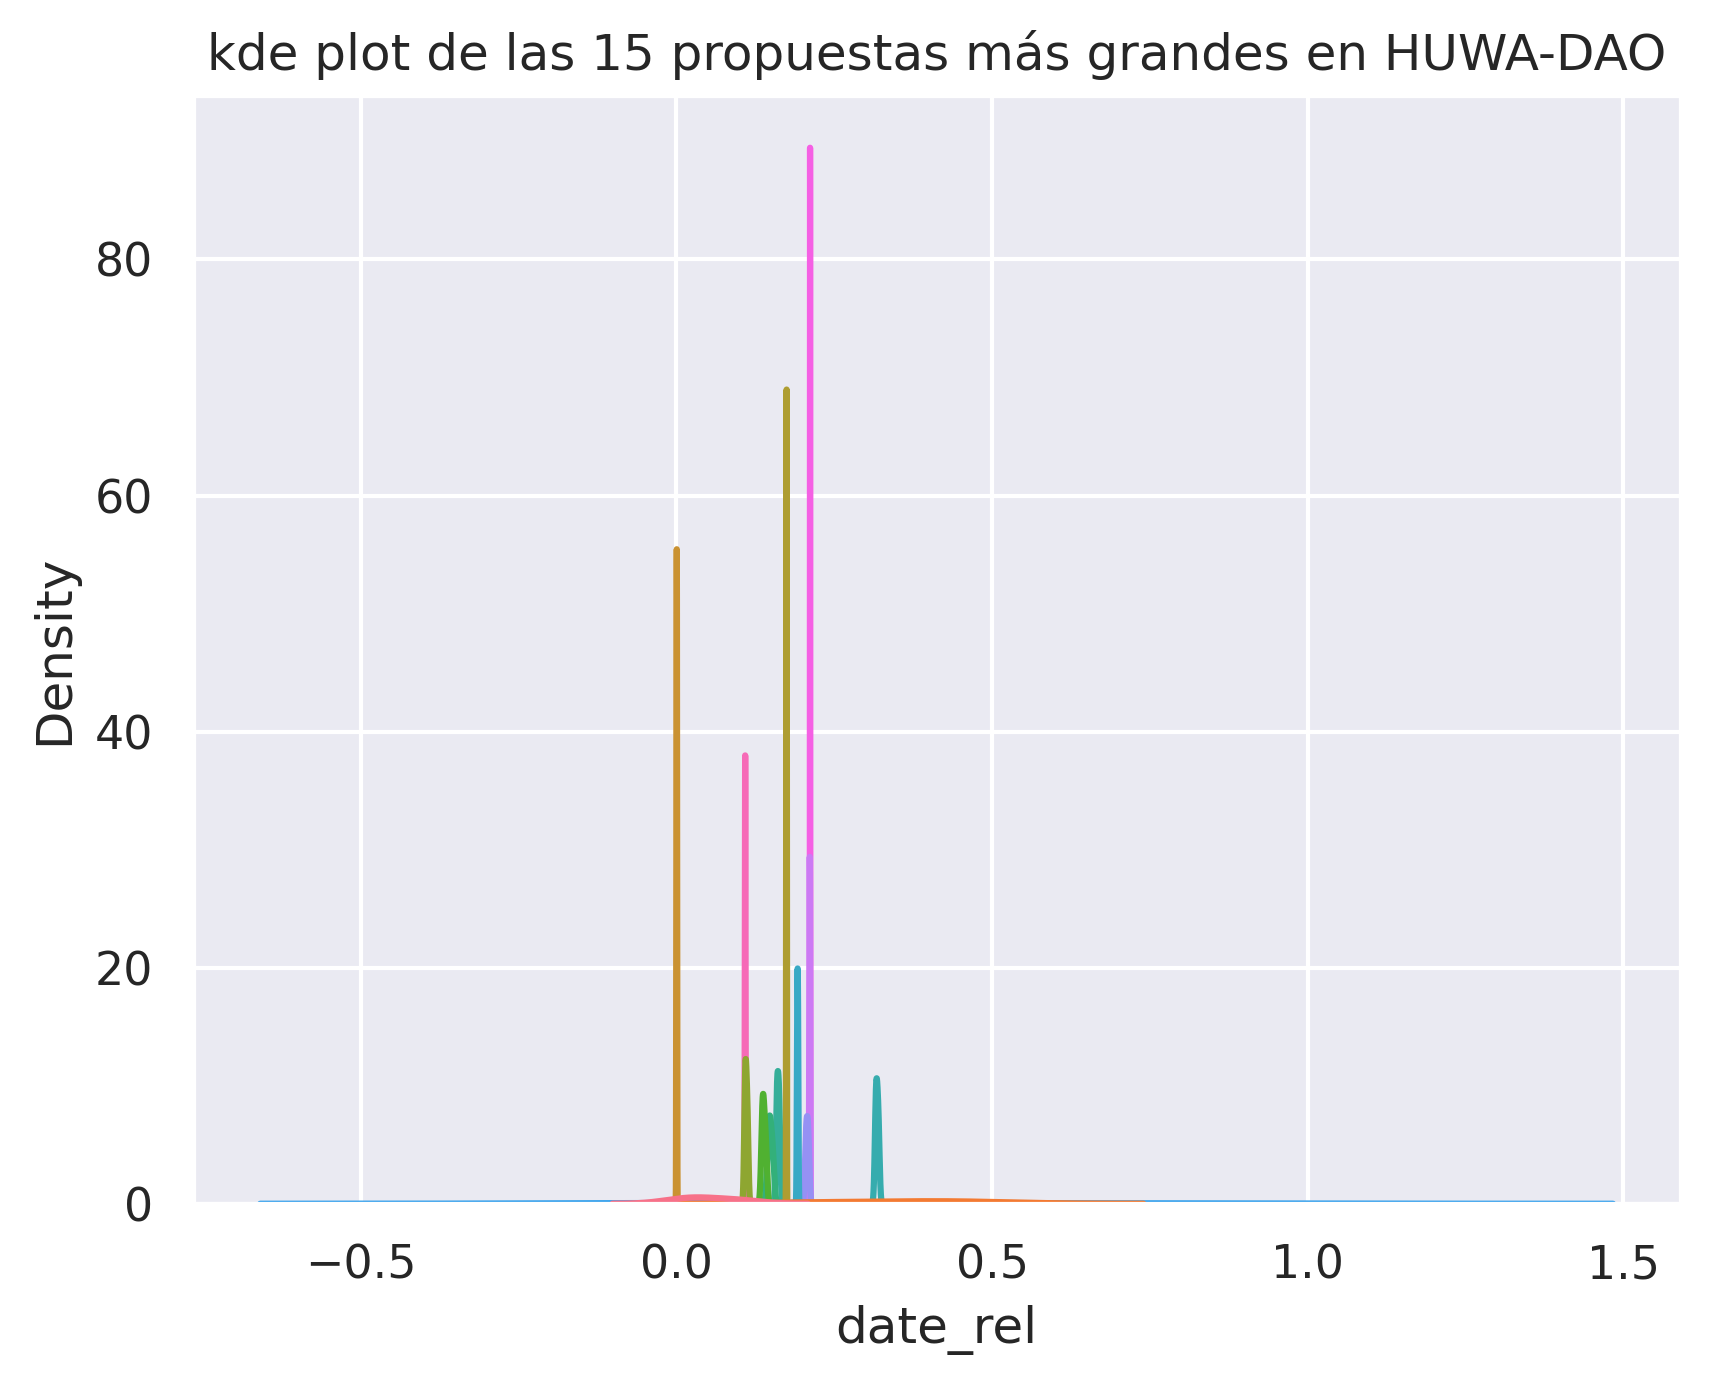

In [27]:
# Get N random proposals
# proposals = np.random.choice(_dfv2['proposal'].unique(), 15, replace=False, p=_dfv2.groupby('proposal').size() / _dfv2.groupby('proposal').size().sum())

# Get top N proposals
proposals = _dfv2.groupby('proposal').size().tail(15).index

_toplot = _dfv2[_dfv2['proposal'].isin(proposals)].copy()
_toplot['proposal'] = _toplot['proposal'].astype(str)
assert _toplot['proposal'].nunique() == len(proposals)
sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")

Efectivamente, los votos se realizan sobre todo nada más crearse la propuesta. El 25% de los votos ya han sido emitidos cuando aún queda un 95% del tiempo restante, y solo un 22% votan en la segunda mitad del tiempo disponible. Sin embargo, como podemos observar en la figura de `[kde plot de las 15 propuestas más grandes]`, hay propuestas en las que al final puede haber un pequeño repunte de actividad. Recordemos que en las DAOs el resultado de la votación es siempre visible, lo que puede sesgar la participación si los usuarios piensan que el resultado es estable y no va a cambiar.

Al partir el dataset en puntos aleatorios considerando una distribución uniforme, lo más seguro es que nos encontremos que las propuestas con las que entrenamos y testeamos (las _frontera_), tengan, en general más votos en el conjunto de entrenamiento que en el de test. Por esta razón también es necesario un sistema que sea muy resiliente al problema de cold start.